In [244]:
# uses first sheet of scb excel

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy.stats as sps
import requests

sns.set()

In [245]:
def parse_scb_prel(YTD=True):
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=',')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    df[['2015','2016','2017','2018','2019','2020','2015-2019']] = df[['2015','2016','2017','2018','2019','2020','2015-2019']].astype(int)
    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    if YTD:
        df = df.loc[df['2020'] != 0]
        
    df = df.drop('Månad',axis=1)
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    if YTD:
        index = pd.date_range('2020-01-01',periods=len(all_deaths))
    else:
        index = pd.date_range('2020-01-01','2020-12-31')
        
    all_deaths.index = index
    
    return all_deaths
    
    

In [246]:
# days with k homicides in UK
zeros = np.array([0] * 259)
ones = np.array([1] * 387)
twos = np.array([2] * 261)
threes = np.array([3] * 131)
fours = np.array([4] * 40)
fives = np.array([5] * 13)
six = np.array([6] * 3)

data = np.concatenate([zeros,ones,twos,threes,fours,fives,six])


In [247]:
data_mean = data.mean()
data_std = data.std()
print (data_mean)
print (data_std)

1.4122486288848264
1.171366125502726


In [248]:
scb = parse_scb_prel()
scb

2015     2016     2017     2018     2019     2020 2015-2019
2020-01-01  298.096   250.41  347.359  282.558  309.147    260.7   297.655
2020-01-02  274.855  278.006  324.817  320.575  284.415  307.913   296.632
2020-01-03  283.949   299.47  317.644  303.108  279.263  262.753   296.632
2020-01-04  258.687  265.741  312.521  292.833  290.598  279.175   284.358
2020-01-05  270.813  265.741  311.496  298.998  283.385   271.99   286.404
...             ...      ...      ...      ...      ...      ...       ...
2020-08-24  215.236  232.013  231.573  218.854  233.921  168.326   226.054
2020-08-25  220.288  243.256  230.548  216.799   231.86  157.036     228.1
2020-08-26  219.278  239.167  208.006  218.854  229.799  96.4795   222.986
2020-08-27  217.257  235.079  210.055  190.085  248.348  35.9232   219.917
2020-08-28  180.879  210.549  220.301  257.899  232.891  3.07913   219.917

[241 rows x 7 columns]

In [249]:
scb.loc[:'2020-06-30'].sum()

2015         47589.324794
2016         46165.421934
2017         47754.189282
2018         48118.150461
2019         44978.823145
2020         51468.742171
2015-2019    47120.571401
dtype: float64

In [250]:
 # första halvåret
scb.loc[:'2020-06-30'].sum().loc['2020'] - scb.loc[:'2020-06-30'].sum().loc['2015-2019']

4348.1707694731085

In [251]:
last_data_day = scb.index[-1]
last_data_day

Timestamp('2020-08-28 00:00:00', freq='D')

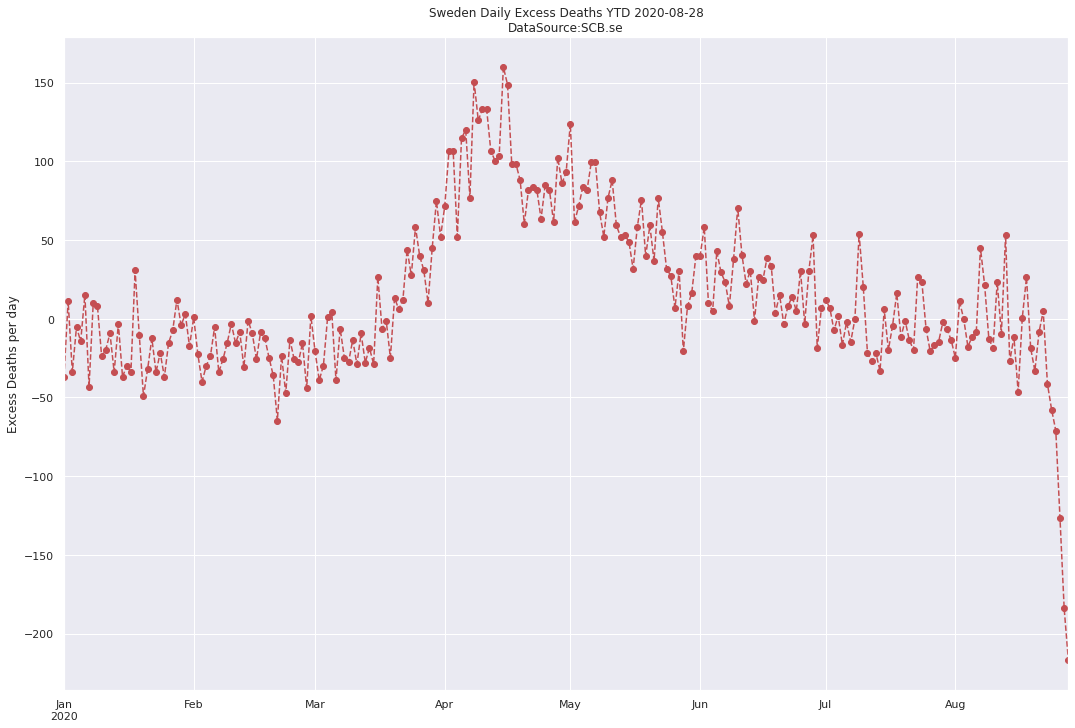

In [252]:
day_excess = scb['2020'][:last_data_day] - scb['2015-2019'][:last_data_day]
idx = day_excess.index.date
day_excess.plot(x=idx,figsize=(18,12),style='ro--',
               title='Sweden Daily Excess Deaths YTD {}\nDataSource:SCB.se'.format(last_data_day.date()))
plt.ylabel('Excess Deaths per day')

plt.savefig('scb_excess_deaths_per_day.jpg',format='jpg')

In [253]:
cumulative_until_last_day = scb[:last_data_day].sum()
cumulative_until_last_day['2020'] / cumulative_until_last_day['2015-2019']

1.0571305291047761

In [254]:
scb_weekly = scb.resample('W-TUE').sum()
print(scb_weekly.loc[:last_data_day].sum())
(scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']).sum()

2015         60238.717888
2016         59141.781234
2017         60380.026001
2018         61192.897202
2019         57507.519346
2020         63872.518128
2015-2019    59885.994179
dtype: float64


3986.5239489151427

In [255]:
scb_weekly

2015         2016         2017         2018         2019  \
2020-01-07  1957.331397  1886.764278  2246.050486  2052.915048  2024.912653   
2020-01-14  1974.509834  1946.045062  2161.003866  1994.348403  1856.942799   
2020-01-21  1957.331397  2012.480424  2139.486047  1998.458343  1887.857496   
2020-01-28  1949.247426  2020.657084  1969.392808  1980.991098  1862.095249   
2020-02-04  1986.635790  1973.641289  1960.170885  1904.957207  1928.046602   
2020-02-11  1938.131966  1955.243804  1878.198240  2037.502773  1903.314845   
2020-02-18  2071.517482  1822.373081  2053.414769  2079.629658  1807.479284   
2020-02-25  2171.556619  1915.382587  2122.066860  2174.158279  1906.406315   
2020-03-03  1761.295108  1845.880978  1794.176278  1928.589362  1539.551910   
2020-03-10  2049.286563  1938.890485  1919.184562  2282.044205  1741.527931   
2020-03-17  1905.796084  1789.666441  1879.222898  2162.855944  1884.766027   
2020-03-24  1866.386727  1879.609700  1762.411878  2080.657143  1681.759516   
2020-03-31  1999.772243  1777.401451  1784.954355  1974.826187  1715.765683   
2020-04-07  1824.956377  1819.306833  1887.420162  2041.612713  1749.771850   
2020-04-14  1852.239778  1747.761059  1744.992691  1876.187627  1661.149718   
2020-04-21  1867.397223  1793.754771  1768.559826  1716.927450  1788.930466   
2020-04-28  1729.969722  1761.048131  1840.285891  1706.652600  1749.771850   
2020-05-05  1678.434409  1680.303614  1763.436536  1716.927450  1662.180208   
2020-05-12  1665.297956  1606.713675  1754.214613  1612.123979  1693.094905   
2020-05-19  1692.581357  1611.824088  1669.167994  1568.969609  1604.472774   
2020-05-26  1665.297956  1537.212066  1654.822781  1490.880748  1531.307991   
2020-06-02  1655.192993  1601.603263  1643.551542  1487.798293  1587.984936   
2020-06-09  1613.762644  1526.991241  1649.699490  1574.107034  1591.076405   
2020-06-16  1626.899096  1555.609551  1586.170690  1475.468473  1488.027415   
2020-06-23  1605.678673  1555.609551  1547.233683  1526.842724  1572.527587   
2020-06-30  1522.817974  1603.647428  1574.899451  1671.718110  1558.100728   
2020-07-07  1724.917240  1577.073283  1659.946071  1638.838590  1583.862976   
2020-07-14  1581.426761  1658.839882  1554.406290  1626.508769  1605.503264   
2020-07-21  1530.901944  1609.779923  1578.998084  1767.274216  1527.186031   
2020-07-28  1579.405768  1715.054419  1506.247361  1684.047930  1560.161708   
2020-08-04  1570.311301  1608.757840  1558.504922  1778.576551  1536.460441   
2020-08-11  1550.101375  1569.918706  1591.293980  1508.347993  1595.198365   
2020-08-18  1521.807477  1647.596975  1546.209025  1544.309969  1531.307991   
2020-08-25  1590.521228  1589.338273  1630.230987  1526.842724  1589.015425   
2020-09-01   617.413259   684.795269   638.361977   666.837771   711.038031   

                   2020    2015-2019  
2020-01-07  1927.537546  2034.489255  
2020-01-14  1916.247390  1987.437216  
2020-01-21  1838.242676  1999.711661  
2020-01-28  1841.321809  1956.751104  
2020-02-04  1841.321809  1951.636752  
2020-02-11  1819.767875  1942.430918  
2020-02-18  1871.086766  1966.979808  
2020-02-25  1822.847009  2058.015275  
2020-03-03  1797.187563  1972.094160  
2020-03-10  1879.297789  1985.391475  
2020-03-17  1831.058031  1924.019250  
2020-03-24  1931.643058  1854.464062  
2020-03-31  2161.551689  1850.372580  
2020-04-07  2513.599282  1864.692766  
2020-04-14  2629.579975  1775.703040  
2020-04-21  2523.863060  1787.977485  
2020-04-28  2318.587496  1758.314243  
2020-05-05  2300.112695  1697.964889  
2020-05-12  2207.738691  1665.233035  
2020-05-19  1989.120216  1629.432571  
2020-05-26  1871.086766  1577.266180  
2020-06-02  1766.396229  1594.654977  
2020-06-09  1747.921428  1591.586366  
2020-06-16  1760.237962  1546.580067  
2020-06-23  1671.969469  1561.923123  
2020-06-30  1689.417892  1585.449143  
2020-07-07  1615.518689  1635.569793  
2020-07-14  1575.489954  1604.883681  
2020-07-21  1573.437198  1601.815070  
2020

In [256]:
scb_weekly.loc[:'2020-07-31'].sum()

2015         54005.976507
2016         52726.169441
2017         54053.787087
2018         54834.819965
2019         51255.537124
2020         57812.783477
2015-2019    53570.792237
dtype: float64

In [257]:
scb_weekly['excess'] = scb_weekly['2020'] - scb_weekly['2015-2019']
scb_weekly['cumexcess'] = scb_weekly['excess'].cumsum()
scb_weekly

2015         2016         2017         2018         2019  \
2020-01-07  1957.331397  1886.764278  2246.050486  2052.915048  2024.912653   
2020-01-14  1974.509834  1946.045062  2161.003866  1994.348403  1856.942799   
2020-01-21  1957.331397  2012.480424  2139.486047  1998.458343  1887.857496   
2020-01-28  1949.247426  2020.657084  1969.392808  1980.991098  1862.095249   
2020-02-04  1986.635790  1973.641289  1960.170885  1904.957207  1928.046602   
2020-02-11  1938.131966  1955.243804  1878.198240  2037.502773  1903.314845   
2020-02-18  2071.517482  1822.373081  2053.414769  2079.629658  1807.479284   
2020-02-25  2171.556619  1915.382587  2122.066860  2174.158279  1906.406315   
2020-03-03  1761.295108  1845.880978  1794.176278  1928.589362  1539.551910   
2020-03-10  2049.286563  1938.890485  1919.184562  2282.044205  1741.527931   
2020-03-17  1905.796084  1789.666441  1879.222898  2162.855944  1884.766027   
2020-03-24  1866.386727  1879.609700  1762.411878  2080.657143  1681.759516   
2020-03-31  1999.772243  1777.401451  1784.954355  1974.826187  1715.765683   
2020-04-07  1824.956377  1819.306833  1887.420162  2041.612713  1749.771850   
2020-04-14  1852.239778  1747.761059  1744.992691  1876.187627  1661.149718   
2020-04-21  1867.397223  1793.754771  1768.559826  1716.927450  1788.930466   
2020-04-28  1729.969722  1761.048131  1840.285891  1706.652600  1749.771850   
2020-05-05  1678.434409  1680.303614  1763.436536  1716.927450  1662.180208   
2020-05-12  1665.297956  1606.713675  1754.214613  1612.123979  1693.094905   
2020-05-19  1692.581357  1611.824088  1669.167994  1568.969609  1604.472774   
2020-05-26  1665.297956  1537.212066  1654.822781  1490.880748  1531.307991   
2020-06-02  1655.192993  1601.603263  1643.551542  1487.798293  1587.984936   
2020-06-09  1613.762644  1526.991241  1649.699490  1574.107034  1591.076405   
2020-06-16  1626.899096  1555.609551  1586.170690  1475.468473  1488.027415   
2020-06-23  1605.678673  1555.609551  1547.233683  1526.842724  1572.527587   
2020-06-30  1522.817974  1603.647428  1574.899451  1671.718110  1558.100728   
2020-07-07  1724.917240  1577.073283  1659.946071  1638.838590  1583.862976   
2020-07-14  1581.426761  1658.839882  1554.406290  1626.508769  1605.503264   
2020-07-21  1530.901944  1609.779923  1578.998084  1767.274216  1527.186031   
2020-07-28  1579.405768  1715.054419  1506.247361  1684.047930  1560.161708   
2020-08-04  1570.311301  1608.757840  1558.504922  1778.576551  1536.460441   
2020-08-11  1550.101375  1569.918706  1591.293980  1508.347993  1595.198365   
2020-08-18  1521.807477  1647.596975  1546.209025  1544.309969  1531.307991   
2020-08-25  1590.521228  1589.338273  1630.230987  1526.842724  1589.015425   
2020-09-01   617.413259   684.795269   638.361977   666.837771   711.038031   

                   2020    2015-2019      excess    cumexcess  
2020-01-07  1927.537546  2034.489255 -106.951709  -106.951709  
2020-01-14  1916.247390  1987.437216  -71.189826  -178.141535  
2020-01-21  1838.242676  1999.711661 -161.468985  -339.610520  
2020-01-28  1841.321809  1956.751104 -115.429294  -455.039814  
2020-02-04  1841.321809  1951.636752 -110.314942  -565.354756  
2020-02-11  1819.767875  1942.430918 -122.663043  -688.017799  
2020-02-18  1871.086766  1966.979808  -95.893042  -783.910840  
2020-02-25  1822.847009  2058.015275 -235.168266 -1019.079106  
2020-03-03  1797.187563  1972.094160 -174.906597 -1193.985703  
2020-03-10  1879.297789  1985.391475 -106.093686 -1300.079390  
2020-03-17  1831.058031  1924.019250  -92.961219 -1393.040609  
2020-03-24  1931.643058  1854.464062   77.178995 -1315.861613  
2020-03-31  2161.551689  1850.372580  311.179109 -1004.682504  
2020-04-07  2513.599282  1864.692766  648.906515  -355.775989  
2020-04-14  2629.579975  1775.703040  853.876935   498.100946  
2020-04-21  2523.863060  1787.977485  735.885575  1233.986521  
2020-04-28  2318.587496  1758.314243  560.273253  1794.259773  
2020-05-05  2300.11269

In [258]:
scb_monthly = scb.resample('M').sum()
scb_monthly['delta'] = scb_monthly['2020'] - scb_monthly['2015-2019']
scb_monthly['cumdelta'] = (scb_monthly['delta'].cumsum())
# last of feb not correct for delta - leap year
scb_monthly

2015         2016         2017         2018         2019  \
2020-01-31  8727.656827  8736.761129  9325.413081  8813.766408  8423.224441   
2020-02-29  8151.673917  7841.416868  8069.182289  8375.030309  7516.393329   
2020-03-31  8709.467893  8185.858667  8275.138561  9463.136934  7800.808541   
2020-04-30  7774.758785  7569.542925  7752.562946  7824.298344  7405.100420   
2020-05-31  7387.738689  7145.378692  7512.792958  6964.293392  7184.575581   
2020-06-30  6838.028684  6686.463653  6819.099446  6677.625074  6648.720833   
2020-07-31  7109.852198  7240.432363  6945.132388  7458.513681  6927.983596   
2020-08-31  6156.954156  6420.722206  6319.066308  6283.070831  6311.750636   

                    2020    2015-2019        delta     cumdelta  
2020-01-31   8334.187900  8807.937142  -473.749242  -473.749242  
2020-02-29   7559.272646  8190.123412  -630.850766 -1104.600009  
2020-03-31   8585.650466  8485.732962    99.917504 -1004.682504  
2020-04-30  10643.537995  7665.390889  2978.147106  1973.464602  
2020-05-31   8929.487036  7236.808185  1692.678850  3666.143452  
2020-06-30   7416.606129  6734.578811   682.027317  4348.170769  
2020-07-31   7004.002245  7132.475403  -128.473158  4219.697612  
2020-08-31   5535.255584  6295.767403  -760.511819  3459.185792

In [259]:
scb_monthly.loc[:'2020-07-31'].sum()

2015         54699.176992
2016         53405.854297
2017         54699.321670
2018         55576.664142
2019         51906.806741
2020         58472.744416
2015-2019    54253.046804
delta         4219.697612
cumdelta     11624.444680
dtype: float64

In [260]:
scb_monthly.loc[:'2020-07-31'].sum()['2020'] / 10.327589

5661.800098334601

In [261]:
data = scb_weekly.iloc[:,0:5]
#data = data.iloc[:9]
data.mean(axis=1)
data

2015         2016         2017         2018         2019
2020-01-07  1957.331397  1886.764278  2246.050486  2052.915048  2024.912653
2020-01-14  1974.509834  1946.045062  2161.003866  1994.348403  1856.942799
2020-01-21  1957.331397  2012.480424  2139.486047  1998.458343  1887.857496
2020-01-28  1949.247426  2020.657084  1969.392808  1980.991098  1862.095249
2020-02-04  1986.635790  1973.641289  1960.170885  1904.957207  1928.046602
2020-02-11  1938.131966  1955.243804  1878.198240  2037.502773  1903.314845
2020-02-18  2071.517482  1822.373081  2053.414769  2079.629658  1807.479284
2020-02-25  2171.556619  1915.382587  2122.066860  2174.158279  1906.406315
2020-03-03  1761.295108  1845.880978  1794.176278  1928.589362  1539.551910
2020-03-10  2049.286563  1938.890485  1919.184562  2282.044205  1741.527931
2020-03-17  1905.796084  1789.666441  1879.222898  2162.855944  1884.766027
2020-03-24  1866.386727  1879.609700  1762.411878  2080.657143  1681.759516
2020-03-31  1999.772243  1777.401451  1784.954355  1974.826187  1715.765683
2020-04-07  1824.956377  1819.306833  1887.420162  2041.612713  1749.771850
2020-04-14  1852.239778  1747.761059  1744.992691  1876.187627  1661.149718
2020-04-21  1867.397223  1793.754771  1768.559826  1716.927450  1788.930466
2020-04-28  1729.969722  1761.048131  1840.285891  1706.652600  1749.771850
2020-05-05  1678.434409  1680.303614  1763.436536  1716.927450  1662.180208
2020-05-12  1665.297956  1606.713675  1754.214613  1612.123979  1693.094905
2020-05-19  1692.581357  1611.824088  1669.167994  1568.969609  1604.472774
2020-05-26  1665.297956  1537.212066  1654.822781  1490.880748  1531.307991
2020-06-02  1655.192993  1601.603263  1643.551542  1487.798293  1587.984936
2020-06-09  1613.762644  1526.991241  1649.699490  1574.107034  1591.076405
2020-06-16  1626.899096  1555.609551  1586.170690  1475.468473  1488.027415
2020-06-23  1605.678673  1555.609551  1547.233683  1526.842724  1572.527587
2020-06-30  1522.817974  1603.647428  1574.899451  1671.718110  1558.100728
2020-07-07  1724.917240  1577.073283  1659.946071  1638.838590  1583.862976
2020-07-14  1581.426761  1658.839882  1554.406290  1626.508769  1605.503264
2020-07-21  1530.901944  1609.779923  1578.998084  1767.274216  1527.186031
2020-07-28  1579.405768  1715.054419  1506.247361  1684.047930  1560.161708
2020-08-04  1570.311301  1608.757840  1558.504922  1778.576551  1536.460441
2020-08-11  1550.101375  1569.918706  1591.293980  1508.347993  1595.198365
2020-08-18  1521.807477  1647.596975  1546.209025  1544.309969  1531.307991
2020-08-25  1590.521228  1589.338273  1630.230987  1526.842724  1589.015425
2020-09-01   617.413259   684.795269   638.361977   666.837771   711.038031

In [262]:
data_min = data.min(axis=1)
data_max = data.max(axis=1)

print (data.mean().mean())

1724.4536455893835


In [263]:
walk = 1000
tune = 500
chains = 2


res_array = np.zeros((len(data),3))
dist_array = np.zeros((len(data),walk*chains))

for i in range(len(data)):
    
    model1 = pm.Model()
    
    with model1:
        
        print ('\n++++++++++++++++++++ processing day ++++++++++++++++++++', i)
        print (data.iloc[i,:])
        print (data.iloc[i,:].mean())

        lambda_ = pm.Exponential('lambda',1/ data.iloc[i,:].mean())
        lkh  = pm.Poisson('lkh',lambda_,observed=data.iloc[i,:])
        
        trace1 = pm.sample(walk,tune=tune)
        post = trace1['lambda'][:]   

        res_array[i,0] = post.min()
        res_array[i,1] = post.mean()
        res_array[i,2] = post.max()

        dist_array[i,:] = post
                     
    


++++++++++++++++++++ processing day ++++++++++++++++++++ 0
2015    1957.331397
2016    1886.764278
2017    2246.050486
2018    2052.915048
2019    2024.912653
Name: 2020-01-07 00:00:00, dtype: float64
2033.594772314751


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 1
2015    1974.509834
2016    1946.045062
2017    2161.003866
2018    1994.348403
2019    1856.942799
Name: 2020-01-14 00:00:00, dtype: float64
1986.5699929640687


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 2
2015    1957.331397
2016    2012.480424
2017    2139.486047
2018    1998.458343
2019    1887.857496
Name: 2020-01-21 00:00:00, dtype: float64
1999.1227413280699


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8957817602585473, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 3
2015    1949.247426
2016    2020.657084
2017    1969.392808
2018    1980.991098
2019    1862.095249
Name: 2020-01-28 00:00:00, dtype: float64
1956.4767327770958


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 4
2015    1986.635790
2016    1973.641289
2017    1960.170885
2018    1904.957207
2019    1928.046602
Name: 2020-02-04 00:00:00, dtype: float64
1950.6903547858124


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8933153895319913, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877375590098409, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 5
2015    1938.131966
2016    1955.243804
2017    1878.198240
2018    2037.502773
2019    1903.314845
Name: 2020-02-11 00:00:00, dtype: float64
1942.4783256448513


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 6
2015    2071.517482
2016    1822.373081
2017    2053.414769
2018    2079.629658
2019    1807.479284
Name: 2020-02-18 00:00:00, dtype: float64
1966.8828549576133


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8874014772982269, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 7
2015    2171.556619
2016    1915.382587
2017    2122.066860
2018    2174.158279
2019    1906.406315
Name: 2020-02-25 00:00:00, dtype: float64
2057.914132036176


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 8
2015    1761.295108
2016    1845.880978
2017    1794.176278
2018    1928.589362
2019    1539.551910
Name: 2020-03-03 00:00:00, dtype: float64
1773.898727258897


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 9
2015    2049.286563
2016    1938.890485
2017    1919.184562
2018    2282.044205
2019    1741.527931
Name: 2020-03-10 00:00:00, dtype: float64
1986.186749125299


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 10
2015    1905.796084
2016    1789.666441
2017    1879.222898
2018    2162.855944
2019    1884.766027
Name: 2020-03-17 00:00:00, dtype: float64
1924.4614786170303


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 11
2015    1866.386727
2016    1879.609700
2017    1762.411878
2018    2080.657143
2019    1681.759516
Name: 2020-03-24 00:00:00, dtype: float64
1854.164992897362


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 12
2015    1999.772243
2016    1777.401451
2017    1784.954355
2018    1974.826187
2019    1715.765683
Name: 2020-03-31 00:00:00, dtype: float64
1850.5439839247858


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 13
2015    1824.956377
2016    1819.306833
2017    1887.420162
2018    2041.612713
2019    1749.771850
Name: 2020-04-07 00:00:00, dtype: float64
1864.613587058321


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 14
2015    1852.239778
2016    1747.761059
2017    1744.992691
2018    1876.187627
2019    1661.149718
Name: 2020-04-14 00:00:00, dtype: float64
1776.4661745149472


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 15
2015    1867.397223
2016    1793.754771
2017    1768.559826
2018    1716.927450
2019    1788.930466
Name: 2020-04-21 00:00:00, dtype: float64
1787.113947275638


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8898144533416029, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 16
2015    1729.969722
2016    1761.048131
2017    1840.285891
2018    1706.652600
2019    1749.771850
Name: 2020-04-28 00:00:00, dtype: float64
1757.5456387857726


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 17
2015    1678.434409
2016    1680.303614
2017    1763.436536
2018    1716.927450
2019    1662.180208
Name: 2020-05-05 00:00:00, dtype: float64
1700.2564435350882


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8892521351151271, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879287065633081, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 18
2015    1665.297956
2016    1606.713675
2017    1754.214613
2018    1612.123979
2019    1693.094905
Name: 2020-05-12 00:00:00, dtype: float64
1666.2890258953662


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8994220002716868, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 19
2015    1692.581357
2016    1611.824088
2017    1669.167994
2018    1568.969609
2019    1604.472774
Name: 2020-05-19 00:00:00, dtype: float64
1629.4031642939792


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 20
2015    1665.297956
2016    1537.212066
2017    1654.822781
2018    1490.880748
2019    1531.307991
Name: 2020-05-26 00:00:00, dtype: float64
1575.9043084278526


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 21
2015    1655.192993
2016    1601.603263
2017    1643.551542
2018    1487.798293
2019    1587.984936
Name: 2020-06-02 00:00:00, dtype: float64
1595.2262052846193


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8890093798547563, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 22
2015    1613.762644
2016    1526.991241
2017    1649.699490
2018    1574.107034
2019    1591.076405
Name: 2020-06-09 00:00:00, dtype: float64
1591.1273627681398


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8923943765981954, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 23
2015    1626.899096
2016    1555.609551
2017    1586.170690
2018    1475.468473
2019    1488.027415
Name: 2020-06-16 00:00:00, dtype: float64
1546.435044961508


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8931157200576295, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 24
2015    1605.678673
2016    1555.609551
2017    1547.233683
2018    1526.842724
2019    1572.527587
Name: 2020-06-23 00:00:00, dtype: float64
1561.578443490304


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 25
2015    1522.817974
2016    1603.647428
2017    1574.899451
2018    1671.718110
2019    1558.100728
Name: 2020-06-30 00:00:00, dtype: float64
1586.2367381504241


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8983830821470218, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 26
2015    1724.917240
2016    1577.073283
2017    1659.946071
2018    1638.838590
2019    1583.862976
Name: 2020-07-07 00:00:00, dtype: float64
1636.9276318895568


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8854847430855559, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 27
2015    1581.426761
2016    1658.839882
2017    1554.406290
2018    1626.508769
2019    1605.503264
Name: 2020-07-14 00:00:00, dtype: float64
1605.3369932330406


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8884754326212654, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 28
2015    1530.901944
2016    1609.779923
2017    1578.998084
2018    1767.274216
2019    1527.186031
Name: 2020-07-21 00:00:00, dtype: float64
1602.8280394970147


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8890441709148286, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 29
2015    1579.405768
2016    1715.054419
2017    1506.247361
2018    1684.047930
2019    1560.161708
Name: 2020-07-28 00:00:00, dtype: float64
1608.9834372363566


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 30
2015    1570.311301
2016    1608.757840
2017    1558.504922
2018    1778.576551
2019    1536.460441
Name: 2020-08-04 00:00:00, dtype: float64
1610.5222109605274


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8786213130359033, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 31
2015    1550.101375
2016    1569.918706
2017    1591.293980
2018    1508.347993
2019    1595.198365
Name: 2020-08-11 00:00:00, dtype: float64
1562.9720837180666


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8835226208967737, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 32
2015    1521.807477
2016    1647.596975
2017    1546.209025
2018    1544.309969
2019    1531.307991
Name: 2020-08-18 00:00:00, dtype: float64
1558.2462874148434


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 33
2015    1590.521228
2016    1589.338273
2017    1630.230987
2018    1526.842724
2019    1589.015425
Name: 2020-08-25 00:00:00, dtype: float64
1585.1897273182462


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9013742116564126, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 34
2015    617.413259
2016    684.795269
2017    638.361977
2018    666.837771
2019    711.038031
Name: 2020-09-01 00:00:00, dtype: float64
663.68926128699


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.


In [264]:
dist_array

array([[2030.35442088, 2020.23821345, 2025.58220829, ..., 1985.13307237,
        2001.3990011 , 1991.12446394],
       [1982.31118533, 1947.21290796, 2032.29403309, ..., 1983.94309647,
        1997.84048769, 1969.0343795 ],
       [2039.08682915, 2018.32438763, 2005.9336313 , ..., 1995.99328856,
        1985.20388697, 1985.20388697],
       ...,
       [1569.14690989, 1564.2944038 , 1565.803319  , ..., 1562.07742468,
        1568.0715677 , 1555.87969158],
       [1581.55159504, 1583.6628242 , 1571.41731549, ..., 1576.5586225 ,
        1584.6151784 , 1582.47333114],
       [ 642.42463047,  679.56795482,  660.39697218, ...,  669.76197782,
         669.76197782,  673.03309926]])

In [265]:
N = 1000

lambdas_per_week = np.zeros((len(dist_array),N))
samples_per_week = np.zeros((len(dist_array),N))

for week in range(len(dist_array)):
    
    lambdas_per_week[week] = np.random.choice(dist_array[week],replace=True,size=N)
    pois_dist = pm.Poisson.dist(lambdas_per_week[week])
    samples_per_week[week] = pois_dist.random(size=N)

In [266]:
print (lambdas_per_week[:5])
samples_per_week[:5]

[[2055.58126694 2000.704137   2046.72418503 ... 2035.08564241
  2011.69770624 2013.63072434]
 [1940.69635347 1982.92808011 1978.77859466 ... 1984.19215087
  1965.42615851 1967.18211805]
 [2002.2442761  2009.12130492 2030.8908344  ... 1980.79655253
  1990.92980309 2014.22306475]
 [1961.37695983 1990.73463453 1934.22508002 ... 1948.68789476
  1956.45902528 1930.09087979]
 [1946.79689331 1951.49489245 1954.56758438 ... 1975.23941078
  1933.29823504 1953.39926733]]


array([[2127., 1992., 2065., ..., 2060., 2025., 2011.],
       [1899., 1976., 1964., ..., 2015., 1966., 2054.],
       [2044., 2031., 1997., ..., 2028., 1996., 2064.],
       [1995., 2033., 1881., ..., 1965., 1985., 1847.],
       [1945., 1988., 1999., ..., 1969., 1992., 2102.]])

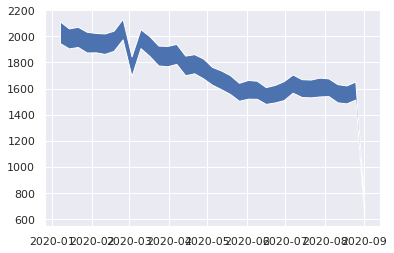

In [267]:
ci_samples = np.percentile(samples_per_week,[5.5,94.5],axis=1)
ci_samples

plt.fill_between(scb_weekly.index,ci_samples[0],ci_samples[1])

In [268]:
res_array

array([[1969.32352522, 2031.77734788, 2102.84714896],
       [1922.71308256, 1986.09216518, 2050.61607176],
       [1924.11967667, 1998.21023653, 2063.30400716],
       [1890.50847979, 1956.90386801, 2020.72102672],
       [1876.85710528, 1950.92931412, 2028.5277123 ],
       [1867.9273174 , 1942.23106881, 2006.78259629],
       [1894.32180324, 1966.68524646, 2039.06957123],
       [1983.42862032, 2056.29586114, 2118.66151237],
       [1709.8667209 , 1772.27306235, 1835.14273805],
       [1920.01877043, 1985.97857513, 2061.00821852],
       [1854.25890711, 1922.98732678, 1986.42944911],
       [1796.88611969, 1853.06873344, 1916.64818091],
       [1789.61335598, 1848.9379479 , 1905.97204781],
       [1795.32277016, 1865.02803624, 1928.44197851],
       [1708.0934184 , 1776.28137642, 1840.76124394],
       [1720.61003347, 1785.47729003, 1841.52228505],
       [1694.86908396, 1757.22469539, 1815.94435725],
       [1642.08703511, 1699.48941383, 1762.8965893 ],
       [1606.21026506, 1665.

In [269]:
errors_low = np.abs(res_array[:,1] - res_array[:,0])
errors_low = errors_low[:-1]
errors_high = np.abs(res_array[:,1] - res_array[:,2]) 
errors_high = errors_high[:-1]
print (errors_low)
print (errors_high)

errors = np.array((errors_low,errors_high))
errors

[62.45382266 63.37908263 74.09055986 66.39538821 74.07220884 74.30375141
 72.36344322 72.86724082 62.40634145 65.95980469 68.72841968 56.18261375
 59.32459192 69.70526608 68.18795801 64.86725656 62.35561144 57.40237871
 59.15657463 71.82790986 58.37586374 69.44486345 58.08287219 63.3470947
 58.36686738 72.77465847 60.74761698 59.06534286 65.48062304 52.03856862
 59.32551314 56.81872966 63.25009263 67.13612714]
[71.06980108 64.52390657 65.09377063 63.81715871 77.59839818 64.55152748
 72.38432478 62.36565123 62.8696757  75.02964339 63.44212233 63.57944747
 57.03409991 63.41394228 64.47986752 56.04499501 58.71966186 63.40717547
 61.63139117 66.14906914 60.12140543 57.69927004 61.00944944 60.08318096
 61.189287   56.64937368 59.79960937 62.10276961 66.55165411 59.68094277
 59.83600353 64.26699936 65.78229606 58.97330717]


array([[62.45382266, 63.37908263, 74.09055986, 66.39538821, 74.07220884,
        74.30375141, 72.36344322, 72.86724082, 62.40634145, 65.95980469,
        68.72841968, 56.18261375, 59.32459192, 69.70526608, 68.18795801,
        64.86725656, 62.35561144, 57.40237871, 59.15657463, 71.82790986,
        58.37586374, 69.44486345, 58.08287219, 63.3470947 , 58.36686738,
        72.77465847, 60.74761698, 59.06534286, 65.48062304, 52.03856862,
        59.32551314, 56.81872966, 63.25009263, 67.13612714],
       [71.06980108, 64.52390657, 65.09377063, 63.81715871, 77.59839818,
        64.55152748, 72.38432478, 62.36565123, 62.8696757 , 75.02964339,
        63.44212233, 63.57944747, 57.03409991, 63.41394228, 64.47986752,
        56.04499501, 58.71966186, 63.40717547, 61.63139117, 66.14906914,
        60.12140543, 57.69927004, 61.00944944, 60.08318096, 61.189287  ,
        56.64937368, 59.79960937, 62.10276961, 66.55165411, 59.68094277,
        59.83600353, 64.26699936, 65.78229606, 58.97330717]])

2020-01-07   -106.951709
2020-01-14    -71.189826
2020-01-21   -161.468985
2020-01-28   -115.429294
2020-02-04   -110.314942
2020-02-11   -122.663043
2020-02-18    -95.893042
2020-02-25   -235.168266
2020-03-03   -174.906597
2020-03-10   -106.093686
2020-03-17    -92.961219
2020-03-24     77.178995
2020-03-31    311.179109
2020-04-07    648.906515
2020-04-14    853.876935
2020-04-21    735.885575
2020-04-28    560.273253
2020-05-05    602.147806
2020-05-12    542.505656
2020-05-19    359.687645
2020-05-26    293.820586
2020-06-02    171.741252
2020-06-09    156.335062
2020-06-16    213.657894
2020-06-23    110.046346
2020-06-30    103.968749
2020-07-07    -20.051104
2020-07-14    -29.393727
2020-07-21    -28.377871
2020-07-28    -28.356827
2020-08-04    -54.009258
2020-08-11     38.203406
2020-08-18    -14.155893
2020-08-25   -225.505546
Freq: W-TUE, dtype: float64
2020-01-07    -106.951709
2020-01-14    -178.141535
2020-01-21    -339.610520
2020-01-28    -455.039814
2020-02-04    -565

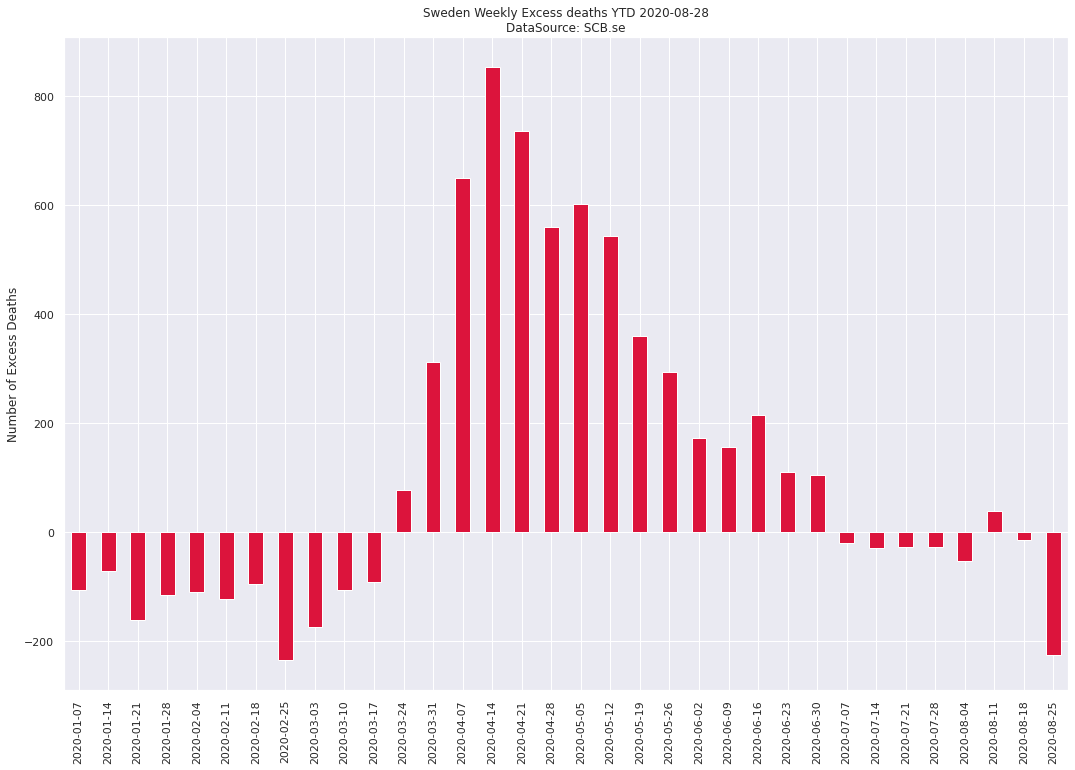

In [270]:
excess = scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']
print (excess)
current_excess = excess.cumsum()
print (current_excess)
excess.index = excess.index.date
excess.plot.bar(x=excess.index,title='Sweden Weekly Excess deaths YTD {}\nDataSource: SCB.se'.format(last_data_day.date()),
                y=excess,
                figsize=(18,12),
                color='crimson')
plt.ylabel('Number of Excess Deaths')
plt.savefig('swe_excess_deaths.jpg',format='jpg',dpi=400)

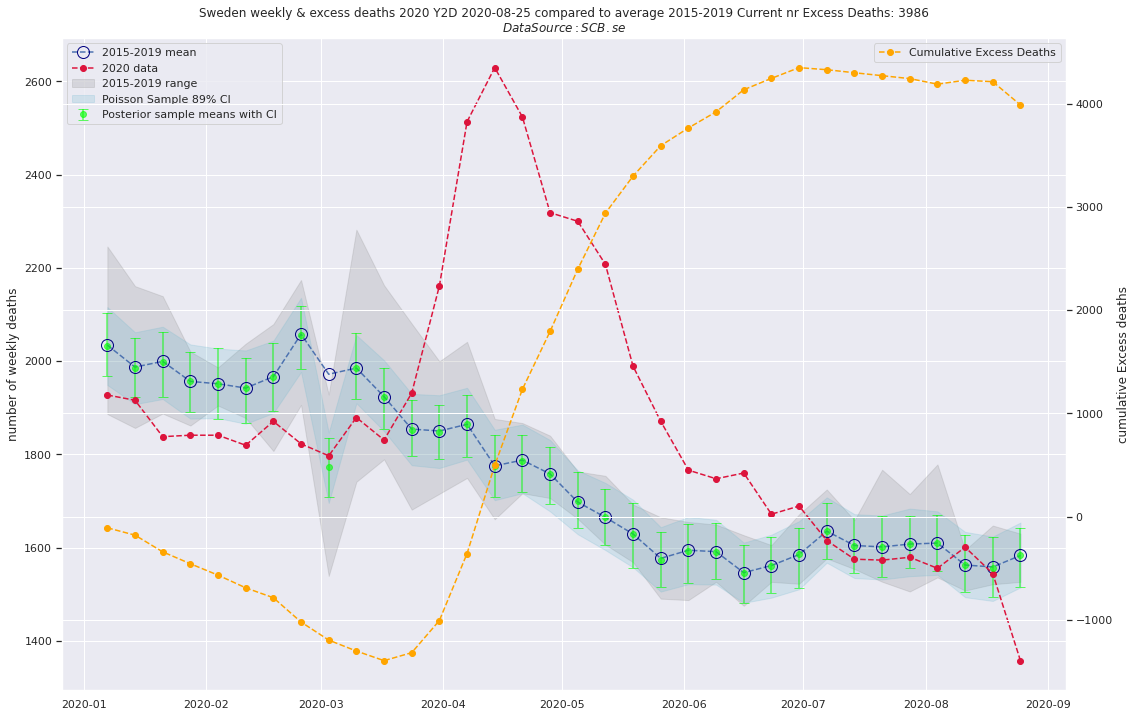

In [271]:
plt.figure(figsize=(18,12))
plt.title('Sweden weekly & excess deaths 2020 Y2D '\
          '{} compared to average 2015-2019 Current nr Excess Deaths: {}\n$Data Source: SCB.se$'.format(
    excess.index[-1],int(current_excess[-1])))
ax = plt.gca()
ax2 = plt.twinx()

ax.errorbar(scb_weekly.index[:len(data) - 1],res_array[:-1,1],yerr=errors,
             fmt='o',capsize=5,color='lime',alpha=0.6,label='Posterior sample means with CI')

ax.plot(scb_weekly.index[:len(data) -1],scb_weekly['2015-2019'][:-1],'o--',
        markerfacecolor='none',markeredgecolor='navy',markersize=12,
        label='2015-2019 mean')

ax.plot(scb_weekly[:last_data_day].index,scb_weekly.loc[:last_data_day,'2020'],'o--',
         color='crimson',label='2020 data')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=data_min[:-1],y2=data_max[:-1],color='grey',
                 alpha=0.2,label='2015-2019 range')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=ci_samples[0][:-1],y2=ci_samples[1][:-1],color='c',
                 alpha=0.2,label='Poisson Sample 89% CI')



ax2.plot(excess.index,excess.cumsum(),'o--',ls='dashed',color='orange',label='Cumulative Excess Deaths')
ax.set_ylabel('number of weekly deaths')
ax2.set_ylabel('cumulative Excess deaths')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('scb_poisson_weekly.jpg',format='jpg',dpi=400)

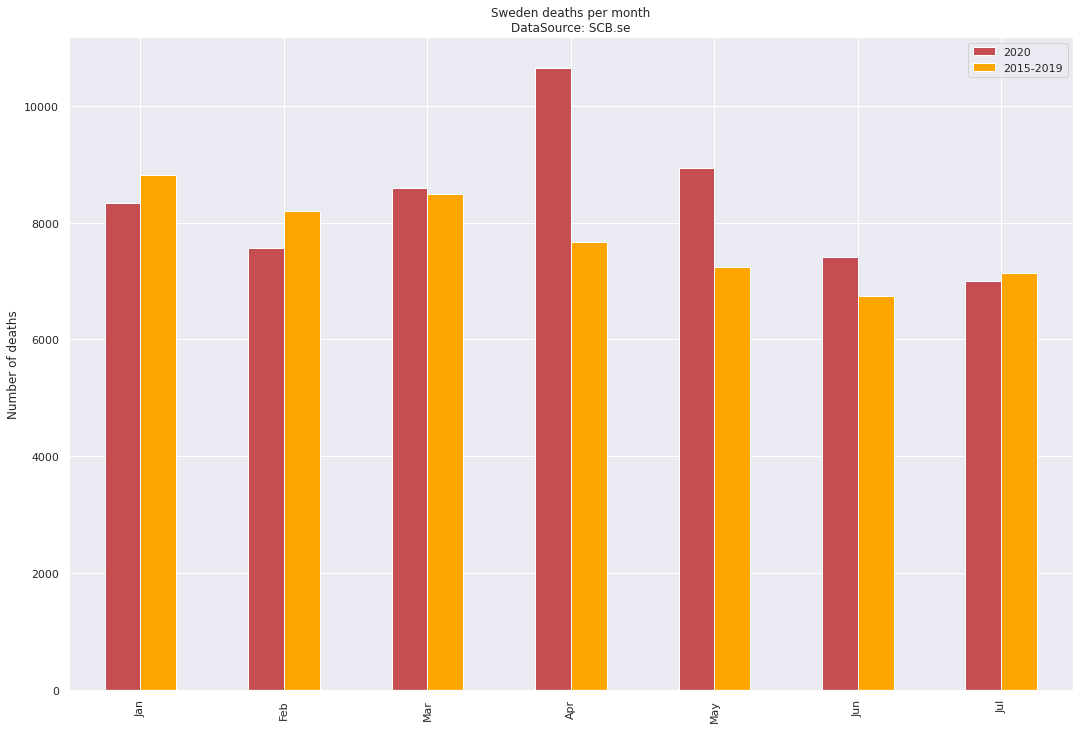

In [272]:
#scb_monthly.index = scb_monthly.index.date
scb_monthly[['2020','2015-2019']][:pd.Timestamp('2020-07-31')].plot.bar(color=['r','orange'],
                                                                        title='Sweden deaths per month\nDataSource: SCB.se',figsize=(18,12))
plt.ylabel('Number of deaths')
plt.xticks(range(len(scb_monthly[:pd.Timestamp('2020-07-31')])),['Jan','Feb','Mar','Apr','May','Jun','Jul'])
plt.savefig('scb_monthly_deaths.jpg',format='jpg')

In [273]:
### population 2014-2019
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'
data = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2014",  
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [274]:
r = requests.post(url,json=data)
r.status_code

200

In [275]:
json = r.json()

In [276]:
data_list = []

for rec in range(len(json['data'])):
    data_list.append((json['data'][rec]['key'][0],json['data'][rec]['key'][1],json['data'][rec]['values'][0]))

In [277]:
population = pd.DataFrame(data_list,columns=['gender','year','population'])
population = population.set_index('year')
population['population'] = population['population'].astype(int)

In [278]:
population = population.groupby(population.index).sum()
population['growth'] = population['population'] / population['population'].shift()


population.loc['2020','population'] = population.loc['2019','population']  
population['population'] = population['population'].astype(int)
population

population    growth
year                      
2014     9747355       NaN
2015     9851017  1.010635
2016     9995153  1.014632
2017    10120242  1.012515
2018    10230185  1.010864
2019    10327589  1.009521
2020    10327589       NaN

In [279]:
pop = population['population']
pop = pop.shift()
pop

year
2014           NaN
2015     9747355.0
2016     9851017.0
2017     9995153.0
2018    10120242.0
2019    10230185.0
2020    10327589.0
Name: population, dtype: float64

In [280]:
pop.drop('2014',inplace=True)
pop

year
2015     9747355.0
2016     9851017.0
2017     9995153.0
2018    10120242.0
2019    10230185.0
2020    10327589.0
Name: population, dtype: float64

In [353]:
weekly_deaths = scb_weekly.loc[:,'2015':'2020'].copy()
weekly_deaths['2015-2018'] = weekly_deaths.loc[:,'2015':'2018'].mean(axis=1)

weekly_deaths_no_truncate = weekly_deaths.copy()
weekly_deaths = weekly_deaths[:-1]
weekly_deaths

2015         2016         2017         2018         2019  \
2020-01-07  1957.331397  1886.764278  2246.050486  2052.915048  2024.912653   
2020-01-14  1974.509834  1946.045062  2161.003866  1994.348403  1856.942799   
2020-01-21  1957.331397  2012.480424  2139.486047  1998.458343  1887.857496   
2020-01-28  1949.247426  2020.657084  1969.392808  1980.991098  1862.095249   
2020-02-04  1986.635790  1973.641289  1960.170885  1904.957207  1928.046602   
2020-02-11  1938.131966  1955.243804  1878.198240  2037.502773  1903.314845   
2020-02-18  2071.517482  1822.373081  2053.414769  2079.629658  1807.479284   
2020-02-25  2171.556619  1915.382587  2122.066860  2174.158279  1906.406315   
2020-03-03  1761.295108  1845.880978  1794.176278  1928.589362  1539.551910   
2020-03-10  2049.286563  1938.890485  1919.184562  2282.044205  1741.527931   
2020-03-17  1905.796084  1789.666441  1879.222898  2162.855944  1884.766027   
2020-03-24  1866.386727  1879.609700  1762.411878  2080.657143  1681.759516   
2020-03-31  1999.772243  1777.401451  1784.954355  1974.826187  1715.765683   
2020-04-07  1824.956377  1819.306833  1887.420162  2041.612713  1749.771850   
2020-04-14  1852.239778  1747.761059  1744.992691  1876.187627  1661.149718   
2020-04-21  1867.397223  1793.754771  1768.559826  1716.927450  1788.930466   
2020-04-28  1729.969722  1761.048131  1840.285891  1706.652600  1749.771850   
2020-05-05  1678.434409  1680.303614  1763.436536  1716.927450  1662.180208   
2020-05-12  1665.297956  1606.713675  1754.214613  1612.123979  1693.094905   
2020-05-19  1692.581357  1611.824088  1669.167994  1568.969609  1604.472774   
2020-05-26  1665.297956  1537.212066  1654.822781  1490.880748  1531.307991   
2020-06-02  1655.192993  1601.603263  1643.551542  1487.798293  1587.984936   
2020-06-09  1613.762644  1526.991241  1649.699490  1574.107034  1591.076405   
2020-06-16  1626.899096  1555.609551  1586.170690  1475.468473  1488.027415   
2020-06-23  1605.678673  1555.609551  1547.233683  1526.842724  1572.527587   
2020-06-30  1522.817974  1603.647428  1574.899451  1671.718110  1558.100728   
2020-07-07  1724.917240  1577.073283  1659.946071  1638.838590  1583.862976   
2020-07-14  1581.426761  1658.839882  1554.406290  1626.508769  1605.503264   
2020-07-21  1530.901944  1609.779923  1578.998084  1767.274216  1527.186031   
2020-07-28  1579.405768  1715.054419  1506.247361  1684.047930  1560.161708   
2020-08-04  1570.311301  1608.757840  1558.504922  1778.576551  1536.460441   
2020-08-11  1550.101375  1569.918706  1591.293980  1508.347993  1595.198365   
2020-08-18  1521.807477  1647.596975  1546.209025  1544.309969  1531.307991   
2020-08-25  1590.521228  1589.338273  1630.230987  1526.842724  1589.015425   

                   2020    2015-2018  
2020-01-07  1927.537546  2035.765302  
2020-01-14  1916.247390  2018.976791  
2020-01-21  1838.242676  2026.939053  
2020-01-28  1841.321809  1980.072104  
2020-02-04  1841.321809  1956.351293  
2020-02-11  1819.767875  1952.269196  
2020-02-18  1871.086766  2006.733748  
2020-02-25  1822.847009  2095.791086  
2020-03-03  1797.187563  1832.485432  
2020-03-10  1879.297789  2047.351454  
2020-03-17  1831.058031  1934.385342  
2020-03-24  1931.643058  1897.266362  
2020-03-31  2161.551689  1884.238559  
2020-04-07  2513.599282  1893.324021  
2020-04-14  2629.579975  1805.295289  
2020-04-21  2523.863060  1786.659818  
2020-04-28  2318.587496  1759.489086  
2020-05-05  2300.112695  1709.775502  
2020-05-12  2207.738691  1659.587556  
2020-05-19  1989.120216  1635.635762  
2020-05-26  1871.086766  1587.053388  
2020-06-02  1766.396229  1597.036523  
2020-06-09  1747.921428  1591.140102  
2020-06-16  1760.237962  1561.036952  
2020-06-23  1671.969469  1558.841158  
2020-06-30  1689.417892  1593.270741  
2020-07-07  1615.518689  1650.193796  
2020-07-14  1575.489954  1605.295426  
2020-07-21  1573.437198  1621.738542  
2020-07-28  1579.595465  1621.188869  
2020-08-04  1555.988775  1629.037654  
2020-

In [354]:
weekly_deaths_no_truncate

2015         2016         2017         2018         2019  \
2020-01-07  1957.331397  1886.764278  2246.050486  2052.915048  2024.912653   
2020-01-14  1974.509834  1946.045062  2161.003866  1994.348403  1856.942799   
2020-01-21  1957.331397  2012.480424  2139.486047  1998.458343  1887.857496   
2020-01-28  1949.247426  2020.657084  1969.392808  1980.991098  1862.095249   
2020-02-04  1986.635790  1973.641289  1960.170885  1904.957207  1928.046602   
2020-02-11  1938.131966  1955.243804  1878.198240  2037.502773  1903.314845   
2020-02-18  2071.517482  1822.373081  2053.414769  2079.629658  1807.479284   
2020-02-25  2171.556619  1915.382587  2122.066860  2174.158279  1906.406315   
2020-03-03  1761.295108  1845.880978  1794.176278  1928.589362  1539.551910   
2020-03-10  2049.286563  1938.890485  1919.184562  2282.044205  1741.527931   
2020-03-17  1905.796084  1789.666441  1879.222898  2162.855944  1884.766027   
2020-03-24  1866.386727  1879.609700  1762.411878  2080.657143  1681.759516   
2020-03-31  1999.772243  1777.401451  1784.954355  1974.826187  1715.765683   
2020-04-07  1824.956377  1819.306833  1887.420162  2041.612713  1749.771850   
2020-04-14  1852.239778  1747.761059  1744.992691  1876.187627  1661.149718   
2020-04-21  1867.397223  1793.754771  1768.559826  1716.927450  1788.930466   
2020-04-28  1729.969722  1761.048131  1840.285891  1706.652600  1749.771850   
2020-05-05  1678.434409  1680.303614  1763.436536  1716.927450  1662.180208   
2020-05-12  1665.297956  1606.713675  1754.214613  1612.123979  1693.094905   
2020-05-19  1692.581357  1611.824088  1669.167994  1568.969609  1604.472774   
2020-05-26  1665.297956  1537.212066  1654.822781  1490.880748  1531.307991   
2020-06-02  1655.192993  1601.603263  1643.551542  1487.798293  1587.984936   
2020-06-09  1613.762644  1526.991241  1649.699490  1574.107034  1591.076405   
2020-06-16  1626.899096  1555.609551  1586.170690  1475.468473  1488.027415   
2020-06-23  1605.678673  1555.609551  1547.233683  1526.842724  1572.527587   
2020-06-30  1522.817974  1603.647428  1574.899451  1671.718110  1558.100728   
2020-07-07  1724.917240  1577.073283  1659.946071  1638.838590  1583.862976   
2020-07-14  1581.426761  1658.839882  1554.406290  1626.508769  1605.503264   
2020-07-21  1530.901944  1609.779923  1578.998084  1767.274216  1527.186031   
2020-07-28  1579.405768  1715.054419  1506.247361  1684.047930  1560.161708   
2020-08-04  1570.311301  1608.757840  1558.504922  1778.576551  1536.460441   
2020-08-11  1550.101375  1569.918706  1591.293980  1508.347993  1595.198365   
2020-08-18  1521.807477  1647.596975  1546.209025  1544.309969  1531.307991   
2020-08-25  1590.521228  1589.338273  1630.230987  1526.842724  1589.015425   
2020-09-01   617.413259   684.795269   638.361977   666.837771   711.038031   

                   2020    2015-2018  
2020-01-07  1927.537546  2035.765302  
2020-01-14  1916.247390  2018.976791  
2020-01-21  1838.242676  2026.939053  
2020-01-28  1841.321809  1980.072104  
2020-02-04  1841.321809  1956.351293  
2020-02-11  1819.767875  1952.269196  
2020-02-18  1871.086766  2006.733748  
2020-02-25  1822.847009  2095.791086  
2020-03-03  1797.187563  1832.485432  
2020-03-10  1879.297789  2047.351454  
2020-03-17  1831.058031  1934.385342  
2020-03-24  1931.643058  1897.266362  
2020-03-31  2161.551689  1884.238559  
2020-04-07  2513.599282  1893.324021  
2020-04-14  2629.579975  1805.295289  
2020-04-21  2523.863060  1786.659818  
2020-04-28  2318.587496  1759.489086  
2020-05-05  2300.112695  1709.775502  
2020-05-12  2207.738691  1659.587556  
2020-05-19  1989.120216  1635.635762  
2020-05-26  1871.086766  1587.053388  
2020-06-02  1766.396229  1597.036523  
2020-06-09  1747.921428  1591.140102  
2020-06-16  1760.237962  1561.036952  
2020-06-23  1671.969469  1558.841158  
2020-06-30  1689.417892  1593.270741  
2020-07-07  1615.518689  1650.193796  
2020-07-14  1575.489954  1605.295426  
2020-07-21  1573.437198  1621.738542  
2020

In [282]:
weekly_deaths_per_m = weekly_deaths / (pop / 1e6)
weekly_deaths_per_m['2015-2018'] = weekly_deaths_per_m.loc[:,'2015' : '2018'].mean(axis=1)
weekly_deaths_per_m['excess'] = weekly_deaths_per_m['2020'] - weekly_deaths_per_m['2015-2018']
weekly_deaths_per_m['cum_excess'] = weekly_deaths_per_m['excess'].cumsum()
weekly_deaths_per_m['abs_excess'] = weekly_deaths_per_m['cum_excess'] * (pop['2020'] / 1e6)
weekly_deaths_per_m['min'] = weekly_deaths_per_m.loc[:,'2015':'2018'].min(axis=1)
weekly_deaths_per_m['max'] = weekly_deaths_per_m.loc[:,'2015' :'2018'].max(axis=1)
weekly_deaths_per_m

2015   2015-2018        2016        2017        2018  \
2020-01-07  200.806413  204.975661  191.529898  224.713967  202.852367   
2020-01-14  202.568782  203.346720  197.547630  216.205181  197.065288   
2020-01-21  200.806413  204.155452  204.291641  214.052356  197.471399   
2020-01-28  199.977063  199.469737  205.121673  197.034784  195.745428   
2020-02-04  203.812808  197.126579  200.348988  196.112144  188.232377   
2020-02-11  198.836707  196.639620  198.481416  187.910904  201.329452   
2020-02-18  212.520985  202.111880  184.993395  205.441054  205.492088   
2020-02-25  222.784193  211.090358  194.435010  212.309592  214.832637   
2020-03-03  180.694671  184.536639  187.379737  179.504634  190.567514   
2020-03-10  210.240272  206.141549  196.821352  192.011524  225.493047   
2020-03-17  195.519306  194.730456  181.673267  188.013420  213.715833   
2020-03-24  191.476224  191.050028  190.803620  176.326653  205.593616   
2020-03-31  205.160502  189.826744  180.428219  178.581994  195.136261   
2020-04-07  187.225804  190.619261  184.682133  188.833544  201.735563   
2020-04-14  190.024861  181.854426  177.419353  174.583890  185.389601   
2020-04-21  191.579892  180.065682  182.088283  176.941746  169.652806   
2020-04-28  177.480939  177.251113  178.768155  184.117831  168.637529   
2020-05-05  172.193832  172.211849  170.571588  176.429169  169.652806   
2020-05-12  170.846138  167.187737  163.101300  175.506529  159.296979   
2020-05-19  173.645195  164.823956  163.620070  166.997743  155.032815   
2020-05-26  170.846138  159.942850  156.046027  165.562526  147.316709   
2020-06-02  169.809450  160.959740  162.582530  164.434856  147.012126   
2020-06-09  165.559030  160.289480  155.008487  165.049949  155.540454   
2020-06-16  166.906725  157.327026  157.913599  158.693988  145.793794   
2020-06-23  164.729680  157.077964  157.913599  154.798399  150.870179   
2020-06-30  156.228841  160.442696  162.790038  157.566318  165.185586   
2020-07-07  176.962596  166.266708  160.092433  166.075104  161.936700   
2020-07-14  162.241630  161.717190  168.392754  155.516008  160.718367   
2020-07-21  157.058191  163.268699  163.412562  157.976380  174.627664   
2020-07-28  162.034292  163.308804  174.099224  150.697779  166.403919   
2020-08-04  161.101273  164.020155  163.308808  155.926070  175.744468   
2020-08-11  159.027898  156.660825  159.366155  159.206565  149.042680   
2020-08-18  156.125172  157.667166  167.251460  154.695884  152.596150   
2020-08-25  163.174649  159.621116  161.337481  163.102154  150.870179   

                  2019        2020     excess  cum_excess   abs_excess  \
2020-01-07  197.935096  186.639645 -18.336016  -18.336016  -189.366840   
2020-01-14  181.516053  185.546442 -17.800279  -36.136295  -373.200803   
2020-01-21  184.537963  177.993400 -26.162052  -62.298347  -643.391728   
2020-01-28  182.019704  178.291546 -21.178191  -83.476538  -862.111377   
2020-02-04  188.466445  178.291546 -18.835033 -102.311571 -1056.631859   
2020-02-11  186.048917  176.204521 -20.435098 -122.746670 -1267.677158   
2020-02-18  176.680997  181.173628 -20.938253 -143.684922 -1483.918825   
2020-02-25  186.351108  176.502668 -34.587691 -178.272613 -1841.126278   
2020-03-03  150.491111  174.018114 -10.518525 -188.791138 -1949.757279   
2020-03-10  170.234256  181.968685 -24.172864 -212.964002 -2199.404681   
2020-03-17  184.235772  177.297725 -17.432732 -230.396733 -2379.442769   
2020-03-24  164.391897  187.037174  -4.012854 -234.409588 -2420.885879   
2020-03-31  167.715998  209.298771  19.472027 -214.937560 -2219.786783   
2020-04-07  171.040098  243.386843  52.767582 -162.169978 -1674.824884   
2020-04-14  162.377290  254.617024  72.762598  -89.407380  -923.362679   
2020-04-21  174.867851  244.380664  64.314982  -25.092398  -259.143975   
2020-04-28  171.040098  224.504238  47.253124   22.160726   228.866872   
2020-05-05  162.478021  222.715359  50.503511   72.664237   750.446373   
2020-05-12  165.49993

In [283]:
data = weekly_deaths_per_m.loc[:,'2015' : '2020'].copy()
data_orig = data.copy()

data.drop('2015-2018',axis=1,inplace=True)

data


2015        2016        2017        2018        2019  \
2020-01-07  200.806413  191.529898  224.713967  202.852367  197.935096   
2020-01-14  202.568782  197.547630  216.205181  197.065288  181.516053   
2020-01-21  200.806413  204.291641  214.052356  197.471399  184.537963   
2020-01-28  199.977063  205.121673  197.034784  195.745428  182.019704   
2020-02-04  203.812808  200.348988  196.112144  188.232377  188.466445   
2020-02-11  198.836707  198.481416  187.910904  201.329452  186.048917   
2020-02-18  212.520985  184.993395  205.441054  205.492088  176.680997   
2020-02-25  222.784193  194.435010  212.309592  214.832637  186.351108   
2020-03-03  180.694671  187.379737  179.504634  190.567514  150.491111   
2020-03-10  210.240272  196.821352  192.011524  225.493047  170.234256   
2020-03-17  195.519306  181.673267  188.013420  213.715833  184.235772   
2020-03-24  191.476224  190.803620  176.326653  205.593616  164.391897   
2020-03-31  205.160502  180.428219  178.581994  195.136261  167.715998   
2020-04-07  187.225804  184.682133  188.833544  201.735563  171.040098   
2020-04-14  190.024861  177.419353  174.583890  185.389601  162.377290   
2020-04-21  191.579892  182.088283  176.941746  169.652806  174.867851   
2020-04-28  177.480939  178.768155  184.117831  168.637529  171.040098   
2020-05-05  172.193832  170.571588  176.429169  169.652806  162.478021   
2020-05-12  170.846138  163.101300  175.506529  159.296979  165.499930   
2020-05-19  173.645195  163.620070  166.997743  155.032815  156.837122   
2020-05-26  170.846138  156.046027  165.562526  147.316709  149.685269   
2020-06-02  169.809450  162.582530  164.434856  147.012126  155.225437   
2020-06-09  165.559030  155.008487  165.049949  155.540454  155.527628   
2020-06-16  166.906725  157.913599  158.693988  145.793794  145.454595   
2020-06-23  164.729680  157.913599  154.798399  150.870179  153.714482   
2020-06-30  156.228841  162.790038  157.566318  165.185586  152.304257   
2020-07-07  176.962596  160.092433  166.075104  161.936700  154.822516   
2020-07-14  162.241630  168.392754  155.516008  160.718367  156.937852   
2020-07-21  157.058191  163.412562  157.976380  174.627664  149.282347   
2020-07-28  162.034292  174.099224  150.697779  166.403919  152.505718   
2020-08-04  161.101273  163.308808  155.926070  175.744468  150.188920   
2020-08-11  159.027898  159.366155  159.206565  149.042680  155.930549   
2020-08-18  156.125172  167.251460  154.695884  152.596150  149.685269   
2020-08-25  163.174649  161.337481  163.102154  150.870179  155.326167   

                  2020  
2020-01-07  186.639645  
2020-01-14  185.546442  
2020-01-21  177.993400  
2020-01-28  178.291546  
2020-02-04  178.291546  
2020-02-11  176.204521  
2020-02-18  181.173628  
2020-02-25  176.502668  
2020-03-03  174.018114  
2020-03-10  181.968685  
2020-03-17  177.297725  
2020-03-24  187.037174  
2020-03-31  209.298771  
2020-04-07  243.386843  
2020-04-14  254.617024  
2020-04-21  244.380664  
2020-04-28  224.504238  
2020-05-05  222.715359  
2020-05-12  213.770967  
2020-05-19  192.602573  
2020-05-26  181.173628  
2020-06-02  171.036650  
2020-06-09  169.247772  
2020-06-16  170.440358  
2020-06-23  161.893494  
2020-06-30  163.582990  
2020-07-07  156.427477  
2020-07-14  152.551574  
2020-07-21  152.352809  
2020-07-28  152.949102  
2020-08-04  150.663313  
2020-08-11  155.036127  
2020-08-18  149.570110  
2020-08-25  131.482562

In [284]:
data = data.unstack().reset_index()
data.columns=['year','week','dead_per_m']


In [285]:
data['week']

0     2020-01-07
1     2020-01-14
2     2020-01-21
3     2020-01-28
4     2020-02-04
         ...    
199   2020-07-28
200   2020-08-04
201   2020-08-11
202   2020-08-18
203   2020-08-25
Name: week, Length: 204, dtype: datetime64[ns]

In [286]:
unique_weeks = data['week'].dt.date.unique()
week_idx_map = dict(zip(unique_weeks,range(len(unique_weeks))))

unique_years = data['year'].unique()
year_idx_map = dict(zip(unique_years,range(len(unique_years))))
year_idx_map

{'2015': 0, '2016': 1, '2017': 2, '2018': 3, '2019': 4, '2020': 5}

In [287]:
data['week_idx'] = data['week'].apply(lambda x : week_idx_map[pd.to_datetime(x).date()])
data['year_idx'] = data['year'].apply(lambda x : year_idx_map[x])
data.head(50)

year       week  dead_per_m  week_idx  year_idx
0   2015 2020-01-07  200.806413         0         0
1   2015 2020-01-14  202.568782         1         0
2   2015 2020-01-21  200.806413         2         0
3   2015 2020-01-28  199.977063         3         0
4   2015 2020-02-04  203.812808         4         0
5   2015 2020-02-11  198.836707         5         0
6   2015 2020-02-18  212.520985         6         0
7   2015 2020-02-25  222.784193         7         0
8   2015 2020-03-03  180.694671         8         0
9   2015 2020-03-10  210.240272         9         0
10  2015 2020-03-17  195.519306        10         0
11  2015 2020-03-24  191.476224        11         0
12  2015 2020-03-31  205.160502        12         0
13  2015 2020-04-07  187.225804        13         0
14  2015 2020-04-14  190.024861        14         0
15  2015 2020-04-21  191.579892        15         0
16  2015 2020-04-28  177.480939        16         0
17  2015 2020-05-05  172.193832        17         0
18  2015 2020-05-12  170.846138        18         0
19  2015 2020-05-19  173.645195        19         0
20  2015 2020-05-26  170.846138        20         0
21  2015 2020-06-02  169.809450        21         0
22  2015 2020-06-09  165.559030        22         0
23  2015 2020-06-16  166.906725        23         0
24  2015 2020-06-23  164.729680        24         0
25  2015 2020-06-30  156.228841        25         0
26  2015 2020-07-07  176.962596        26         0
27  2015 2020-07-14  162.241630        27         0
28  2015 2020-07-21  157.058191        28         0
29  2015 2020-07-28  162.034292        29         0
30  2015 2020-08-04  161.101273        30         0
31  2015 2020-08-11  159.027898        31         0
32  2015 2020-08-18  156.125172        32         0
33  2015 2020-08-25  163.174649        33         0
34  2016 2020-01-07  191.529898         0         1
35  2016 2020-01-14  197.547630         1         1
36  2016 2020-01-21  204.291641         2         1
37  2016 2020-01-28  205.121673         3         1
38  2016 2020-02-04  200.348988         4         1
39  2016 2020-02-11  198.481416         5         1
40  2016 2020-02-18  184.993395         6         1
41  2016 2020-02-25  194.435010         7         1
42  2016 2020-03-03  187.379737         8         1
43  2016 2020-03-10  196.821352         9         1
44  2016 2020-03-17  181.673267        10         1
45  2016 2020-03-24  190.803620        11         1
46  2016 2020-03-31  180.428219        12         1
47  2016 2020-04-07  184.682133        13         1
48  2016 2020-04-14  177.419353        14         1
49  2016 2020-04-21  182.088283        15         1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_, lambda_bar]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (35), generating only 20 plots
  warnings.warn(


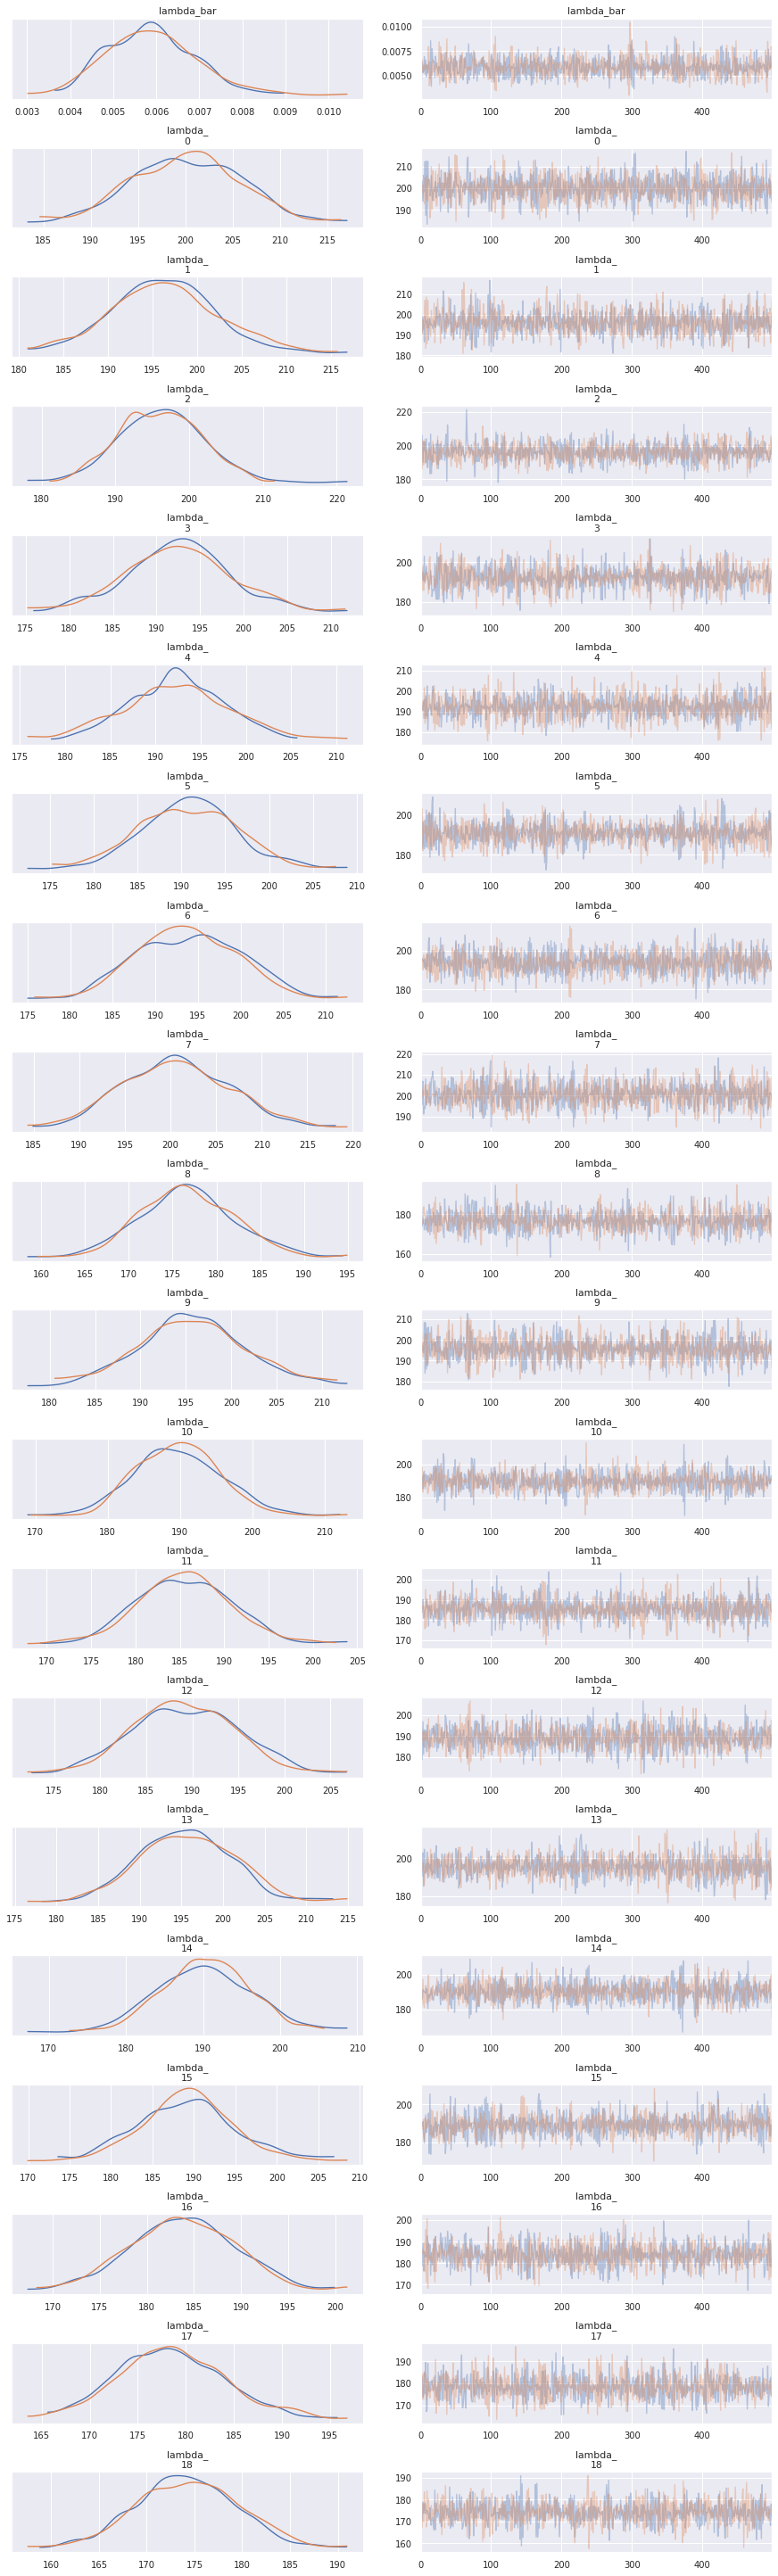

In [288]:
model2 = pm.Model()

week_idx = data['week_idx'].values

with model2:

    lambda_bar = pm.Exponential('lambda_bar',1 / data['dead_per_m'].mean())
    lambda_ = pm.Exponential('lambda_',lambda_bar,shape=len(week_idx_map))
    lkh = pm.Poisson('lkh',lambda_[week_idx],observed=data['dead_per_m'])
    
    trace2 = pm.sample(500,tune=500)
    
    result2 = pm.trace_to_dataframe(trace2)
    summary2 = az.summary(trace2)
    az.plot_trace(trace2)

In [289]:
print (summary2)

                mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
lambda_bar     0.006  0.001    0.004    0.008      0.000    0.000    3000.0   
lambda_[0]   200.041  5.870  188.530  210.212      0.107    0.076    3000.0   
lambda_[1]   196.250  5.870  184.372  207.022      0.118    0.084    2470.0   
lambda_[2]   196.028  5.551  186.274  206.860      0.109    0.077    2588.0   
lambda_[3]   192.465  5.849  181.737  204.115      0.119    0.084    2421.0   
lambda_[4]   192.306  5.640  181.215  202.242      0.103    0.073    3000.0   
lambda_[5]   190.744  5.639  180.292  201.645      0.104    0.074    2942.0   
lambda_[6]   193.781  5.895  183.442  204.591      0.125    0.088    2237.0   
lambda_[7]   200.590  5.850  190.439  212.230      0.107    0.076    3000.0   
lambda_[8]   176.615  5.268  167.397  186.738      0.096    0.068    3000.0   
lambda_[9]   195.683  5.912  183.634  206.315      0.119    0.085    2477.0   
lambda_[10]  189.618  5.704  179.638  199.317      0

In [290]:
result2.describe()

lambda_bar   lambda___0   lambda___1   lambda___2   lambda___3  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.005872   200.040804   196.250300   196.028189   192.465479   
std       0.001009     5.869697     5.870199     5.550566     5.849460   
min       0.003015   183.335699   181.009317   178.107888   175.229485   
25%       0.005143   195.789128   192.295020   192.244919   188.457808   
50%       0.005849   200.000719   196.137904   196.029260   192.478554   
75%       0.006491   204.050759   199.818790   199.819778   196.118675   
max       0.010430   217.082595   216.843629   221.406363   211.870149   

        lambda___4   lambda___5   lambda___6   lambda___7   lambda___8  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean    192.305639   190.744115   193.781327   200.589806   176.615089  ...   
std       5.640282     5.639033     5.895252     5.850431     5.267637  ...   
min     175.870977   172.460219   175.015638   184.355286   158.447217  ...   
25%     188.554596   186.897545   189.417857   196.314446   173.038829  ...   
50%     192.224935   190.741155   193.824654   200.409781   176.515664  ...   
75%     195.878856   194.540516   198.156831   204.589166   179.985313  ...   
max     211.198366   208.902300   212.514288   219.360523   194.934485  ...   

       lambda___24  lambda___25  lambda___26  lambda___27  lambda___28  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    156.454957   159.136745   161.974760   158.827941   158.790882   
std       4.997396     5.592217     5.295971     5.380825     4.946605   
min     142.330791   142.375223   142.891267   141.881302   144.729154   
25%     152.890788   155.195924   158.302135   155.271324   155.215875   
50%     156.501614   159.239647   161.941203   158.895047   158.680855   
75%     160.043023   163.046535   165.805131   162.323179   162.129355   
max     171.840911   175.325143   181.755629   174.218841   173.834212   

       lambda___29  lambda___30  lambda___31  lambda___32  lambda___33  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean    159.448707   158.923587   156.159059   154.538354   153.801062  
std       5.220547     5.120623     5.243348     4.894524     5.532646  
min     143.668577   142.146380   140.165883   141.050199   137.082516  
25%     156.153525   155.764338   152.660346   151.238731   150.210294  
50%     159.435263   158.800733   156.062921   154.421159   153.801334  
75%     162.764893   162.054877   159.551626   157.840487   157.488961  
max     175.826108   174.824853   173.253932   174.021637   170.977546  

[8 rows x 35 columns]

In [291]:
weekly_means = result2.describe().loc['mean','lambda___0' :]

weekly_means

lambda___0     200.040804
lambda___1     196.250300
lambda___2     196.028189
lambda___3     192.465479
lambda___4     192.305639
lambda___5     190.744115
lambda___6     193.781327
lambda___7     200.589806
lambda___8     176.615089
lambda___9     195.682910
lambda___10    189.618273
lambda___11    185.487068
lambda___12    189.109793
lambda___13    195.554556
lambda___14    190.268680
lambda___15    189.089866
lambda___16    183.751996
lambda___17    178.438116
lambda___18    174.166596
lambda___19    167.274016
lambda___20    161.408027
lambda___21    161.359348
lambda___22    160.606007
lambda___23    156.687531
lambda___24    156.454957
lambda___25    159.136745
lambda___26    161.974760
lambda___27    158.827941
lambda___28    158.790882
lambda___29    159.448707
lambda___30    158.923587
lambda___31    156.159059
lambda___32    154.538354
lambda___33    153.801062
Name: mean, dtype: float64

In [292]:
CI = result2.loc[:,'lambda___0':].quantile([0.055,0.945])
CI

lambda___0  lambda___1  lambda___2  lambda___3  lambda___4  lambda___5  \
0.055  190.886094  186.994596  187.015222  182.683029  183.201730  181.886445   
0.945  209.202075  205.983989  204.836704  202.344063  201.257783  199.954304   

       lambda___6  lambda___7  lambda___8  lambda___9  ...  lambda___24  \
0.055  184.470017  191.601121  168.625998  186.253173  ...   148.486349   
0.945  203.004673  209.735350  185.159193  205.365746  ...   164.451029   

       lambda___25  lambda___26  lambda___27  lambda___28  lambda___29  \
0.055   150.359311   153.488241   150.446261   151.236888   151.285508   
0.945   168.261198   170.419200   167.742164   167.234944   168.028066   

       lambda___30  lambda___31  lambda___32  lambda___33  
0.055   151.117108   148.323838   146.955423   144.974666  
0.945   167.401040   165.251659   162.141797   162.862351  

[2 rows x 34 columns]

In [293]:
abs_error = np.abs(weekly_means - CI)
abs_error

lambda___0  lambda___1  lambda___2  lambda___3  lambda___4  lambda___5  \
0.055     9.15471    9.255704    9.012967    9.782450    9.103909    8.857670   
0.945     9.16127    9.733689    8.808516    9.878584    8.952144    9.210189   

       lambda___6  lambda___7  lambda___8  lambda___9  ...  lambda___24  \
0.055    9.311310    8.988685    7.989091    9.429737  ...     7.968607   
0.945    9.223345    9.145544    8.544104    9.682836  ...     7.996073   

       lambda___25  lambda___26  lambda___27  lambda___28  lambda___29  \
0.055     8.777435     8.486518     8.381680     7.553994     8.163199   
0.945     9.124452     8.444441     8.914224     8.444062     8.579359   

       lambda___30  lambda___31  lambda___32  lambda___33  
0.055     7.806479     7.835222     7.582931     8.826396  
0.945     8.477453     9.092600     7.603442     9.061289  

[2 rows x 34 columns]

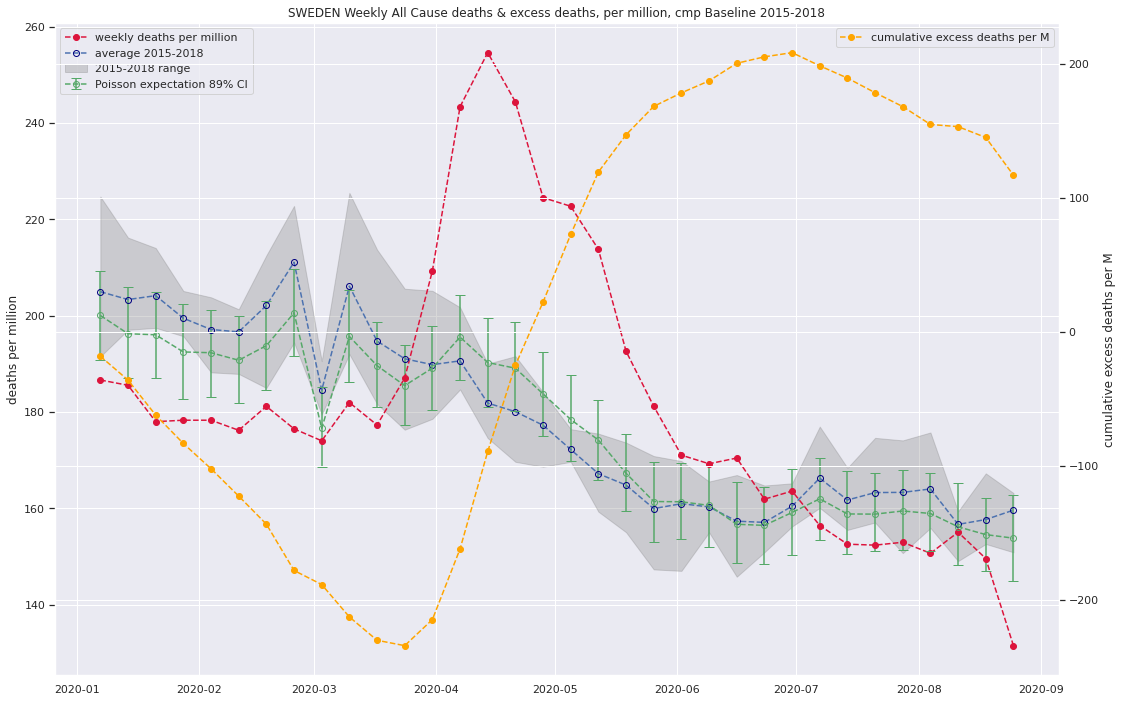

In [294]:
plt.figure(figsize=(18,12))

ax = plt.gca()

ax2 = plt.twinx()

ax.plot(weekly_deaths_per_m.index,weekly_deaths_per_m['2020'],'o--',
         color='crimson',label='weekly deaths per million')


ax.plot(weekly_deaths_per_m.index,weekly_deaths_per_m['2015-2018'],'o--',
         markerfacecolor='none',markeredgecolor='navy',label='average 2015-2018')

ax.fill_between(weekly_deaths_per_m.index,weekly_deaths_per_m['min'],weekly_deaths_per_m['max'],
                color='grey',alpha=0.3,label='2015-2018 range')

ax.errorbar(weekly_deaths_per_m.index,weekly_means,yerr=abs_error.values,
            fmt='o--',capsize=5,mec='g',mfc='none',color='g',label='Poisson expectation 89% CI')


ax.legend(loc='upper left')

ax2.plot(weekly_deaths_per_m.index,weekly_deaths_per_m['cum_excess'],'o--',color='orange',
        label='cumulative excess deaths per M')

plt.title('SWEDEN Weekly All Cause deaths & excess deaths, per million, cmp Baseline 2015-2018')
ax.set_ylabel('deaths per million')
ax2.set_ylabel('cumulative excess deaths per M')
ax2.legend(loc='upper right')

plt.savefig('scb_poisson_per_m.jpg',format='jpg')

In [295]:
post_samples2 = pm.sample_posterior_predictive(trace2,100,model2)
post_samples2

/usr/local/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


{'lkh': array([[197, 212, 183, ..., 150, 147, 148],
        [215, 211, 206, ..., 138, 152, 151],
        [206, 196, 224, ..., 165, 181, 152],
        ...,
        [181, 196, 216, ..., 133, 154, 138],
        [189, 221, 205, ..., 128, 143, 148],
        [205, 208, 227, ..., 158, 136, 160]])}

In [296]:
data_ppc2 = az.from_pymc3(trace=trace2,model=model2,posterior_predictive=post_samples2)
data_ppc2

arviz.data.io_pymc3 - WARNING - posterior predictive variable lkh's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot:xlabel='lkh'>], dtype=object)

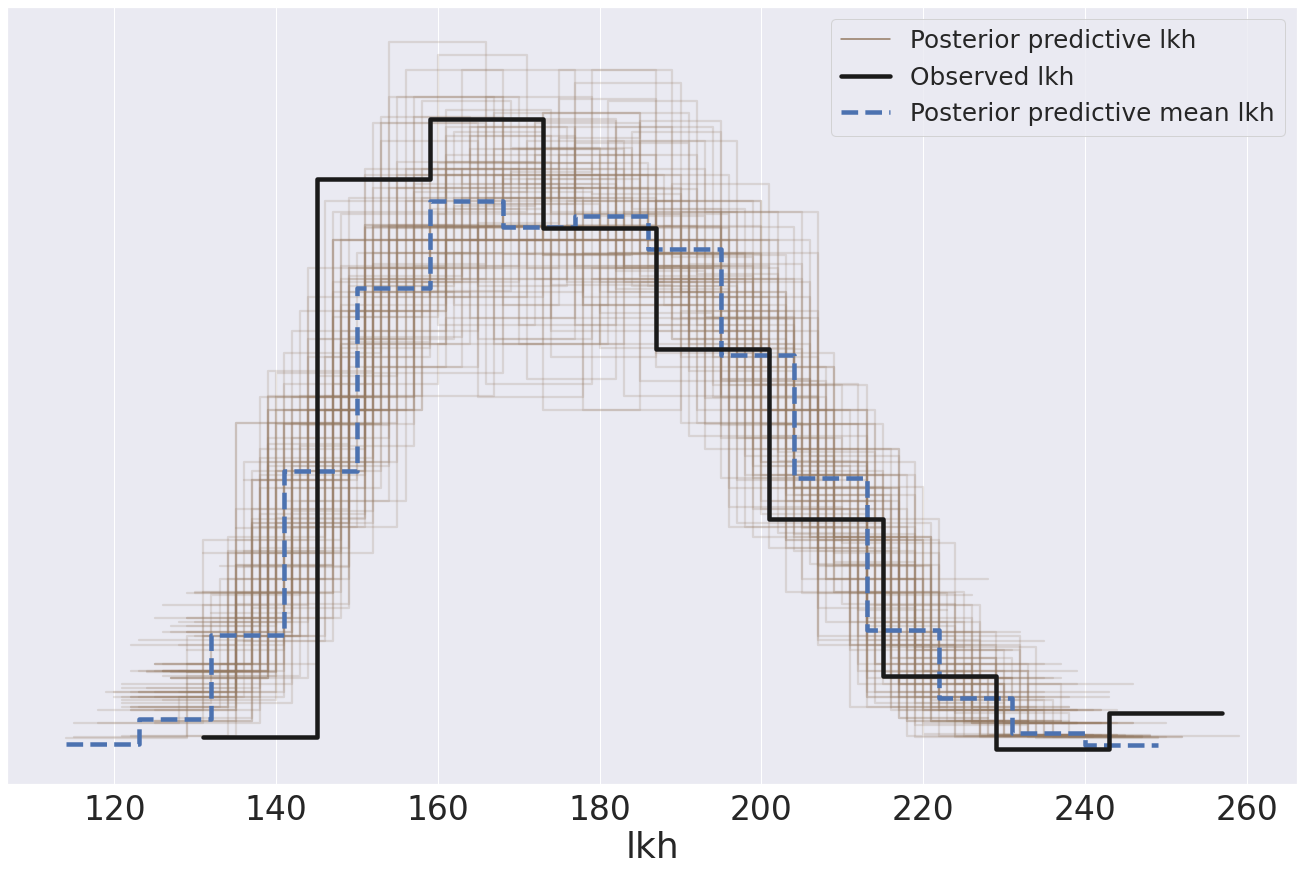

In [297]:
az.plot_ppc(data_ppc2,figsize=(18,12))

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

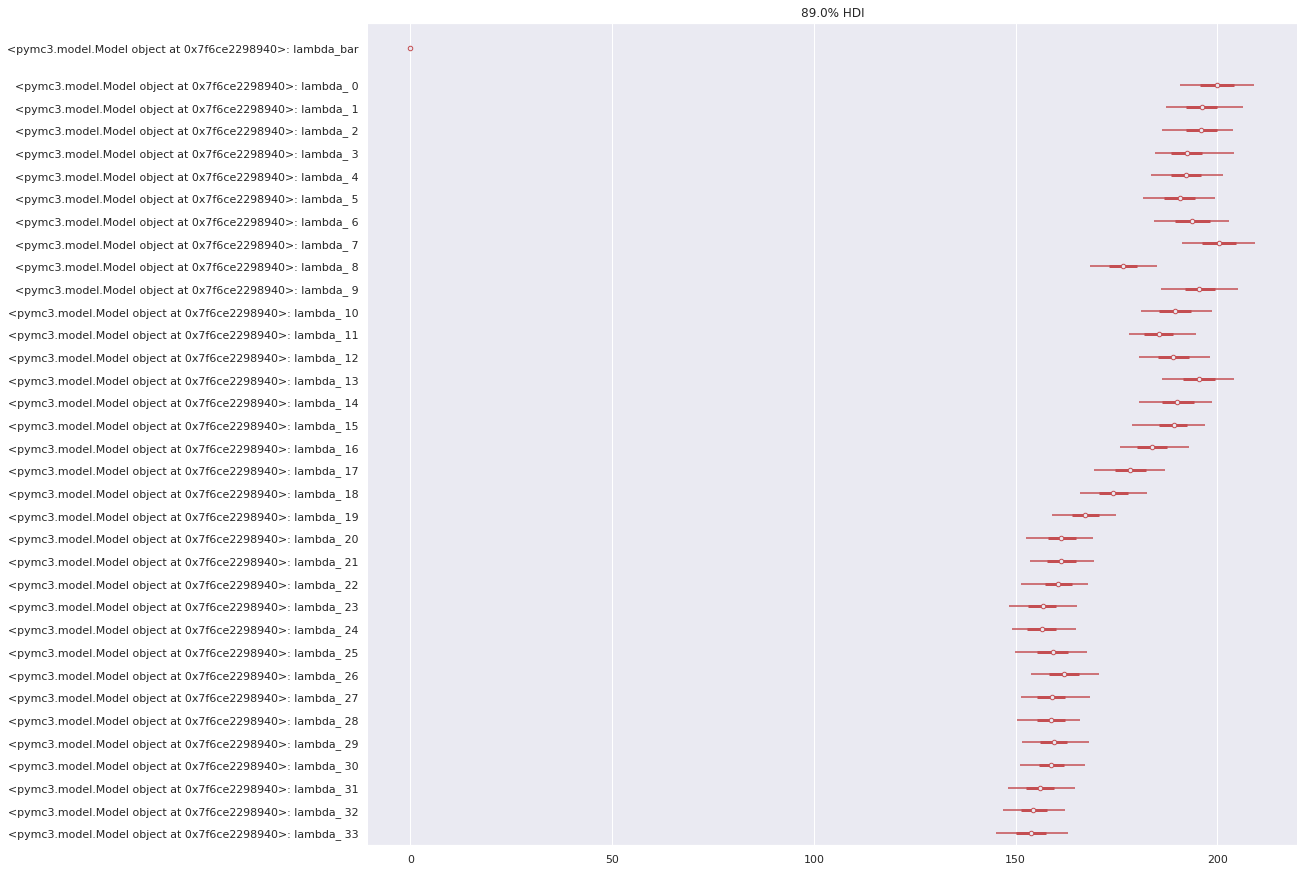

In [298]:
az.plot_forest(trace2,model_names=[model2],figsize=(18,12),combined=True,colors='r',hdi_prob=0.89)


In [299]:
pop

year
2015     9747355.0
2016     9851017.0
2017     9995153.0
2018    10120242.0
2019    10230185.0
2020    10327589.0
Name: population, dtype: float64

In [300]:
data['pop'] = data['year'].apply(lambda x : pop[x])
data

year       week  dead_per_m  week_idx  year_idx         pop
0    2015 2020-01-07  200.806413         0         0   9747355.0
1    2015 2020-01-14  202.568782         1         0   9747355.0
2    2015 2020-01-21  200.806413         2         0   9747355.0
3    2015 2020-01-28  199.977063         3         0   9747355.0
4    2015 2020-02-04  203.812808         4         0   9747355.0
..    ...        ...         ...       ...       ...         ...
199  2020 2020-07-28  152.949102        29         5  10327589.0
200  2020 2020-08-04  150.663313        30         5  10327589.0
201  2020 2020-08-11  155.036127        31         5  10327589.0
202  2020 2020-08-18  149.570110        32         5  10327589.0
203  2020 2020-08-25  131.482562        33         5  10327589.0

[204 rows x 6 columns]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [g, b, a]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 134 seconds.
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (409), generating only 20 plots
  warnings.warn(


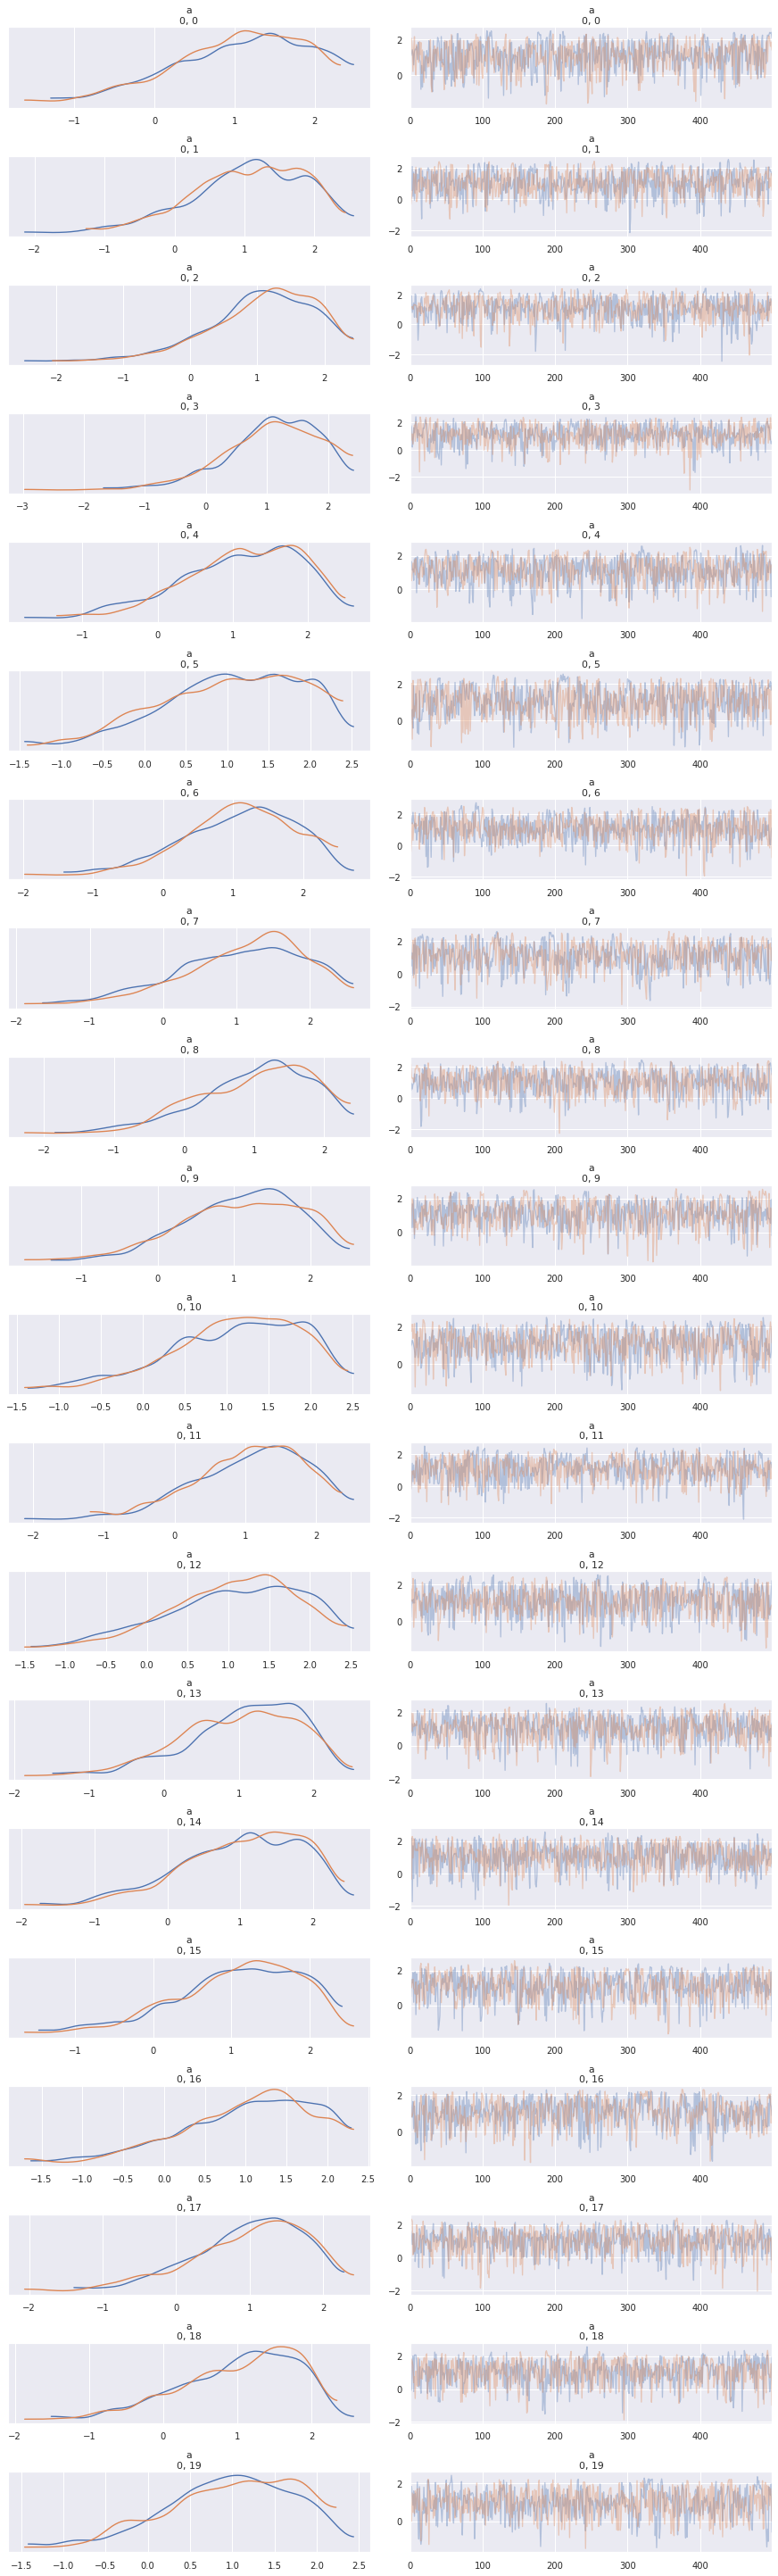

In [301]:
# Scientific, dynamic model, not a GLM

# Delta D = alpha * Pop^beta - gamma

# alpha = deaths per individual
# beta = Elasticity (diminishing returns)
# gamma = death loss (e.g. better health care)

# D ~ Poisson(lambda)
# lambda = exp(a[year_idx,week_idx]) * P^b[year_idx,week_idx] / g
# a = pm.Normal('a',1,1,shape=len(unique_weeks))
# b = pm.Exponential('b',1,shape=len(unique_weeks))
# g = pm.Exponential(1)

model3 = pm.Model()

year_idx = data['year_idx'].values

with model3:
    
    a = pm.Normal('a',mu=1,sigma=1,shape=(len(year_idx_map),len(week_idx_map)))
    b = pm.Exponential('b',1,shape=(len(year_idx_map),len(week_idx_map)))
    g = pm.Exponential('g',1)
    
    lambda_ = np.exp(a[year_idx,week_idx]) * np.log(data['pop'].values) ** b[year_idx,week_idx] / g
    
    lkh = pm.Poisson('lkh',lambda_,observed=data['dead_per_m'].values.astype(int))
    
    step1 = pm.Metropolis()
    trace3 = pm.sample(500,tune=500,target_accept=0.95)
    
    result3 = pm.trace_to_dataframe(trace3)
    summary3 = az.summary(trace3)
    
    _= az.plot_trace(trace3)
    

In [302]:
def alpha_cols(col):
    if 'a_' in col.name:
        return True
    return False

def beta_cols(col):
    if 'b_' in col.name:
        return True
    return False

def gamma_col(col):
    if col.name == 'g':
        return True
    return False

alpha_mask = result3.apply(alpha_cols)
alphas = result3.loc[:,alpha_mask]

beta_mask = result3.apply(beta_cols)
betas = result3.loc[:,beta_mask]

gamma_mask = result3.apply(gamma_col)
gamma = result3.loc[:,gamma_mask]

gamma

g
0    0.053391
1    0.052661
2    0.054020
3    0.043795
4    0.052042
..        ...
995  0.065831
996  0.045383
997  0.057515
998  0.051599
999  0.044287

[1000 rows x 1 columns]

In [303]:
summary3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0,0]   1.043  0.826  -0.457    2.386      0.030    0.025     783.0   546.0   
a[0,1]   1.051  0.786  -0.349    2.363      0.027    0.022     835.0   653.0   
a[0,2]   1.065  0.775  -0.269    2.386      0.028    0.021     785.0   658.0   
a[0,3]   1.070  0.770  -0.211    2.403      0.025    0.020     941.0   771.0   
a[0,4]   1.117  0.780  -0.309    2.379      0.028    0.023     798.0   597.0   
...        ...    ...     ...      ...        ...      ...       ...     ...   
b[5,30]  0.410  0.281   0.000    0.893      0.010    0.007     727.0   727.0   
b[5,31]  0.407  0.269   0.001    0.897      0.009    0.006     917.0   917.0   
b[5,32]  0.395  0.267   0.000    0.863      0.008    0.006    1032.0   917.0   
b[5,33]  0.356  0.251   0.000    0.820      0.009    0.007     712.0   712.0   
g        0.052  0.006   0.042    0.063      0.000    0.000     363.0   360.0   

         ess_bulk  ess_tail  r_hat  
a[0,0]      657.0     446.0   1.01  
a[0,1]      805.0     611.0   1.00  
a[0,2]      730.0     568.0   1.00  
a[0,3]      929.0     759.0   1.00  
a[0,4]      704.0     581.0   1.00  
...           ...       ...    ...  
b[5,30]     616.0     451.0   1.00  
b[5,31]     773.0     562.0   1.00  
b[5,32]     999.0     769.0   1.00  
b[5,33]     651.0     566.0   1.00  
g           364.0     457.0   1.00  

[409 rows x 11 columns]

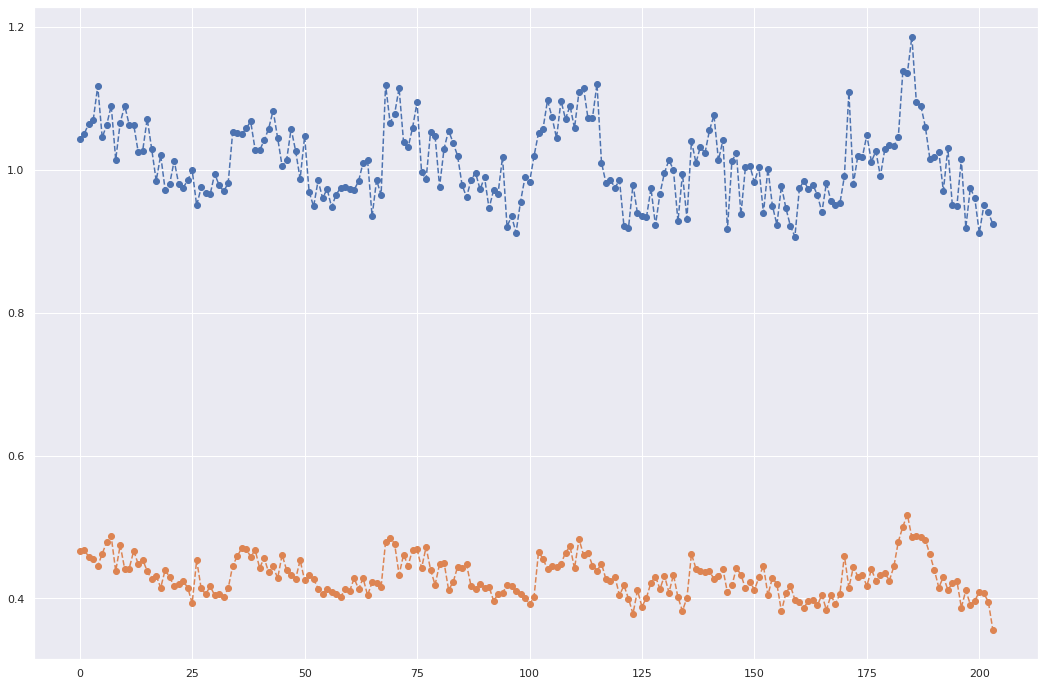

In [304]:
plt.figure(figsize=(18,12))

ax = plt.gca()
ax.plot(range(len(alphas.mean())),alphas.mean(),'o--')

ax.plot(range(len(betas.mean())),betas.mean(),'o--')

In [305]:
alphas

a__0_0    a__0_1    a__0_2    a__0_3    a__0_4    a__0_5    a__0_6  \
0    1.689464  1.997986  1.307659  2.134095  1.052489 -0.401563  0.508748   
1    1.068119  1.251144  0.957214  1.809388  1.435744 -0.210097  1.904525   
2    1.182386  0.573522  1.920040  1.666982  1.643853  0.554366  1.578534   
3    1.420275  2.102151  0.799197  0.182450  1.139087  0.599376  1.369630   
4    1.189640  0.185730  1.130423  0.502285  1.204499 -0.413651  2.104511   
..        ...       ...       ...       ...       ...       ...       ...   
995  2.204622  0.712568  0.586978  1.815411  1.171257  0.641800  2.123892   
996  1.970988  1.345538  1.636149  0.703395  1.792495  1.675837 -0.178474   
997  1.612640  0.832260  1.728957  2.349185  0.954723 -0.211716  2.291042   
998  1.848500  1.653153  0.769388  1.616239  1.364214 -0.173590  2.183412   
999  1.400930  0.578923  1.584757  1.507573  1.461420  1.870215 -0.807738   

       a__0_7    a__0_8    a__0_9  ...   a__5_24   a__5_25   a__5_26  \
0    2.354746  2.096768  0.541925  ...  0.066884  1.548660  1.410364   
1    1.750762  0.445172  1.502260  ...  2.018808  1.427163  0.367723   
2    0.487443  0.918739  0.276218  ...  2.048289  1.399147  0.572231   
3    1.268780  0.564613  1.678116  ...  1.860010  0.649854  0.461829   
4   -0.081525  0.876894  0.284486  ...  2.023011  0.951733  0.368912   
..        ...       ...       ...  ...       ...       ...       ...   
995  1.812527  2.317381  2.291699  ...  1.800781  0.478921  1.429400   
996  1.539998  1.094144 -0.895656  ...  1.219867  1.325458  0.873937   
997  1.868704  0.440624  1.438610  ...  0.492438 -0.946930  1.647149   
998  0.806718 -0.330703  1.391055  ...  0.315835  1.062167  1.929366   
999  1.598499  1.568121  0.460364  ...  1.112703  1.106035 -0.659051   

      a__5_27   a__5_28   a__5_29   a__5_30   a__5_31   a__5_32   a__5_33  
0    1.903294  0.329149  0.299379  1.616987  1.594218  0.602118  1.173785  
1    1.973370  1.314735 -0.157236  0.581860  0.931871  0.637636  0.937671  
2    1.687273  0.802854 -0.003770  1.078087  1.457530  0.014463  1.475798  
3   -0.575885  1.279379  0.492987  1.041399  0.545792  1.483991  0.320423  
4   -1.437449  2.024692  0.811153  1.207906  0.580853  1.191858  1.525381  
..        ...       ...       ...       ...       ...       ...       ...  
995  1.270700  2.061662 -0.128466  1.006270 -0.230336  0.484293  1.007959  
996  0.904907 -0.432376  0.986136  1.395689  1.335791  1.641370  0.779458  
997  1.797716  1.618527  2.066580  1.216889  0.640735  0.450737  0.631491  
998  1.463717  1.461266  1.452676  0.916284  1.092061  0.453522  1.129167  
999  0.241209  0.493836 -0.094993 -0.395808  1.425214  0.447334 -0.187068  

[1000 rows x 204 columns]

(1000, 204)

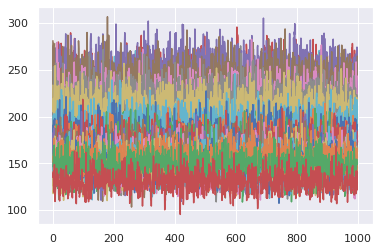

In [306]:
lambdas = np.exp(alphas.values) * np.log(10e6) ** betas.values / gamma.values
plt.plot(range(len(lambdas)),lambdas)

lambdas.shape

In [307]:
samples = pm.Poisson.dist(lambdas.mean(axis=0)).random(size=1000)
samples.shape

(1000, 204)

In [308]:
CI = np.percentile(samples,[5.5,94.5],axis=0)
weekly_mins = data.loc[data['year_idx'].isin([0,1,2,3])].groupby('week_idx').min()['dead_per_m']
weekly_max = data.loc[data['year_idx'].isin([0,1,2,3])].groupby('week_idx').max()['dead_per_m']

weekly_max

week_idx
0     224.713967
1     216.205181
2     214.052356
3     205.121673
4     203.812808
5     201.329452
6     212.520985
7     222.784193
8     190.567514
9     225.493047
10    213.715833
11    205.593616
12    205.160502
13    201.735563
14    190.024861
15    191.579892
16    184.117831
17    176.429169
18    175.506529
19    173.645195
20    170.846138
21    169.809450
22    165.559030
23    166.906725
24    164.729680
25    165.185586
26    176.962596
27    168.392754
28    174.627664
29    174.099224
30    175.744468
31    159.366155
32    167.251460
33    163.174649
Name: dead_per_m, dtype: float64

In [309]:
cols = data['year'].str.cat(data['week_idx'].astype(str),sep='_')

weekly_means = data.loc[data['year_idx'].isin([0,1,2,3])].groupby('week_idx').mean()['dead_per_m']
weekly_means

week_idx
0     204.975661
1     203.346720
2     204.155452
3     199.469737
4     197.126579
5     196.639620
6     202.111880
7     211.090358
8     184.536639
9     206.141549
10    194.730456
11    191.050028
12    189.826744
13    190.619261
14    181.854426
15    180.065682
16    177.251113
17    172.211849
18    167.187737
19    164.823956
20    159.942850
21    160.959740
22    160.289480
23    157.327026
24    157.077964
25    160.442696
26    166.266708
27    161.717190
28    163.268699
29    163.308804
30    164.020155
31    156.660825
32    157.667166
33    159.621116
Name: dead_per_m, dtype: float64

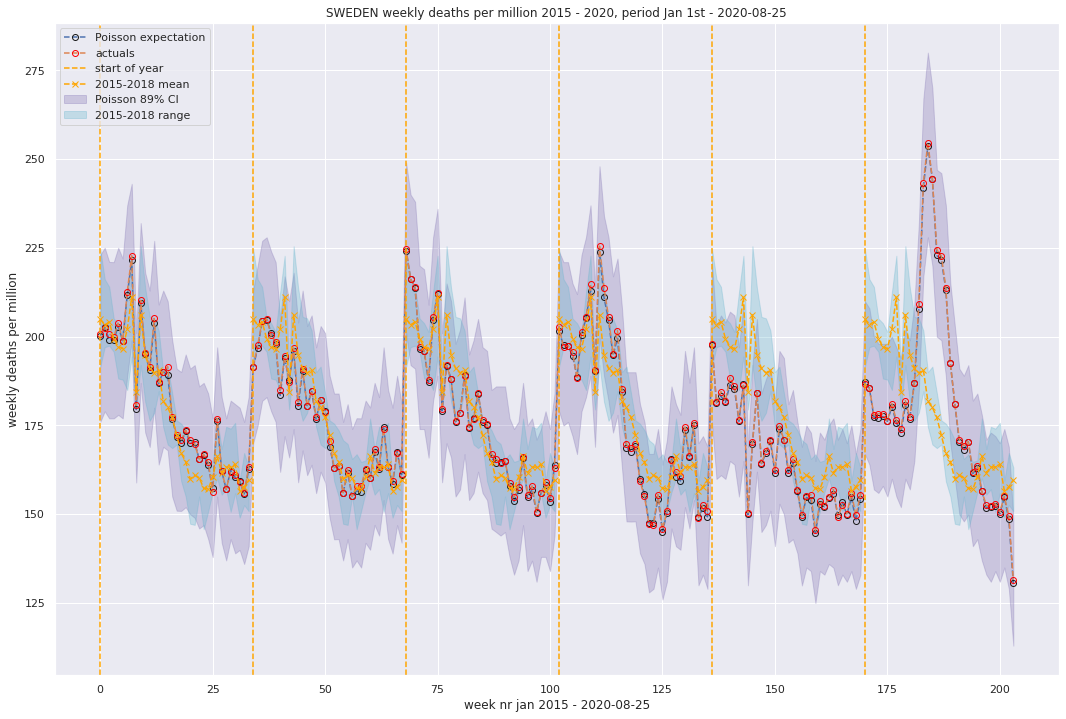

In [310]:
last_week = data.iloc[-1,1].date()

plt.figure(figsize=(18,12))

plt.title('SWEDEN weekly deaths per million 2015 - 2020, period Jan 1st - {}'.format(last_week))

plt.plot(range(len(samples.mean(axis=0))),samples.mean(axis=0),'o--',label='Poisson expectation',
         mec='k',mfc='none')

plt.fill_between(range(len(samples.T)),CI[0],CI[1],color='m',alpha=0.3,label='Poisson 89% CI')

plt.plot(range(len(data)),data['dead_per_m'],'o--',mec='red',mfc='none',label='actuals')


for i in range(len(year_idx_map)):
    
    label = 'start of year' if i == 0 else ''
    label2 = '2015-2018 mean' if i == 0 else ''
    label3 = '2015-2018 range' if i == 0 else ''
    
    plt.axvline(i * len(week_idx_map),ls='--',color='orange',label=label)
    
    plt.plot(range(i*len(week_idx_map),i*len(week_idx_map)+ len(week_idx_map)),weekly_means,'x--',
             color='orange',label=label2)
    
    plt.fill_between(range(i*len(week_idx_map),i*len(week_idx_map) + len(week_idx_map)),
    weekly_mins,weekly_max,alpha=0.3,color='c',label=label3)
    
plt.legend(loc='upper left')

    
plt.ylabel('weekly deaths per million')
plt.xlabel('week nr jan 2015 - {}'.format(last_week))

plt.savefig('scb_weekly_deaths_per_m_2015_2020.jpg',format='jpg',dpi=400)


<AxesSubplot:>

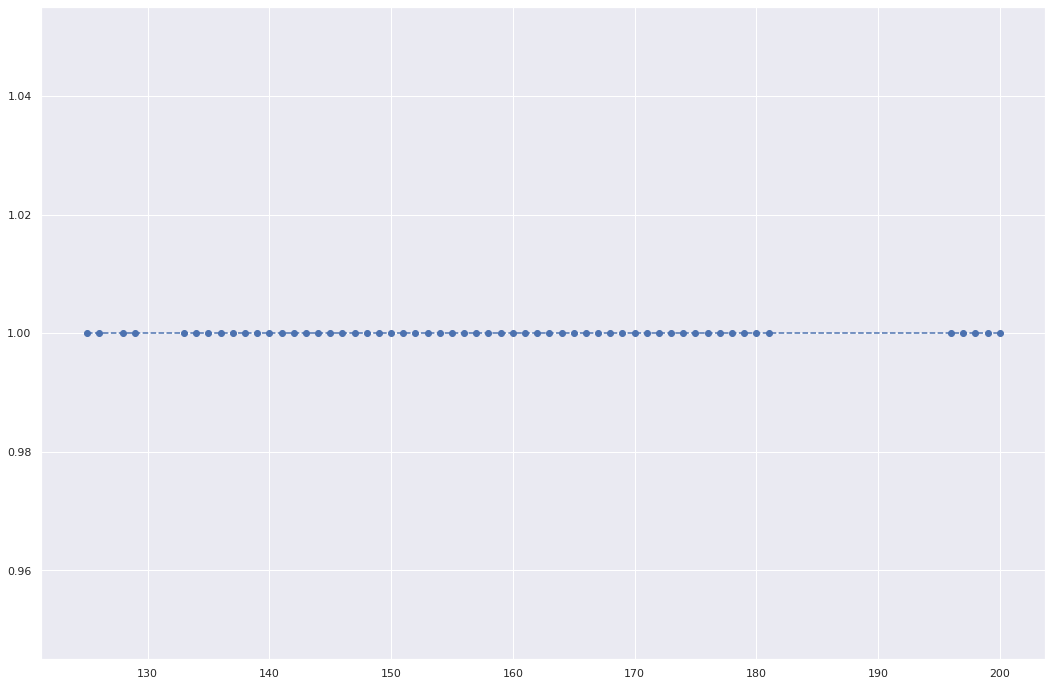

In [311]:
repeat_weekly_means = np.array(list (weekly_means) * 6)
under_mean = ((data['dead_per_m'] - repeat_weekly_means) < 0).astype(int) 
under_mean = under_mean.loc[under_mean==1]
under_mean.loc[125:200].plot(x=under_mean.index,style='o--',figsize=(18,12))

/usr/local/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


arviz.data.io_pymc3 - WARNING - posterior predictive variable lkh's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

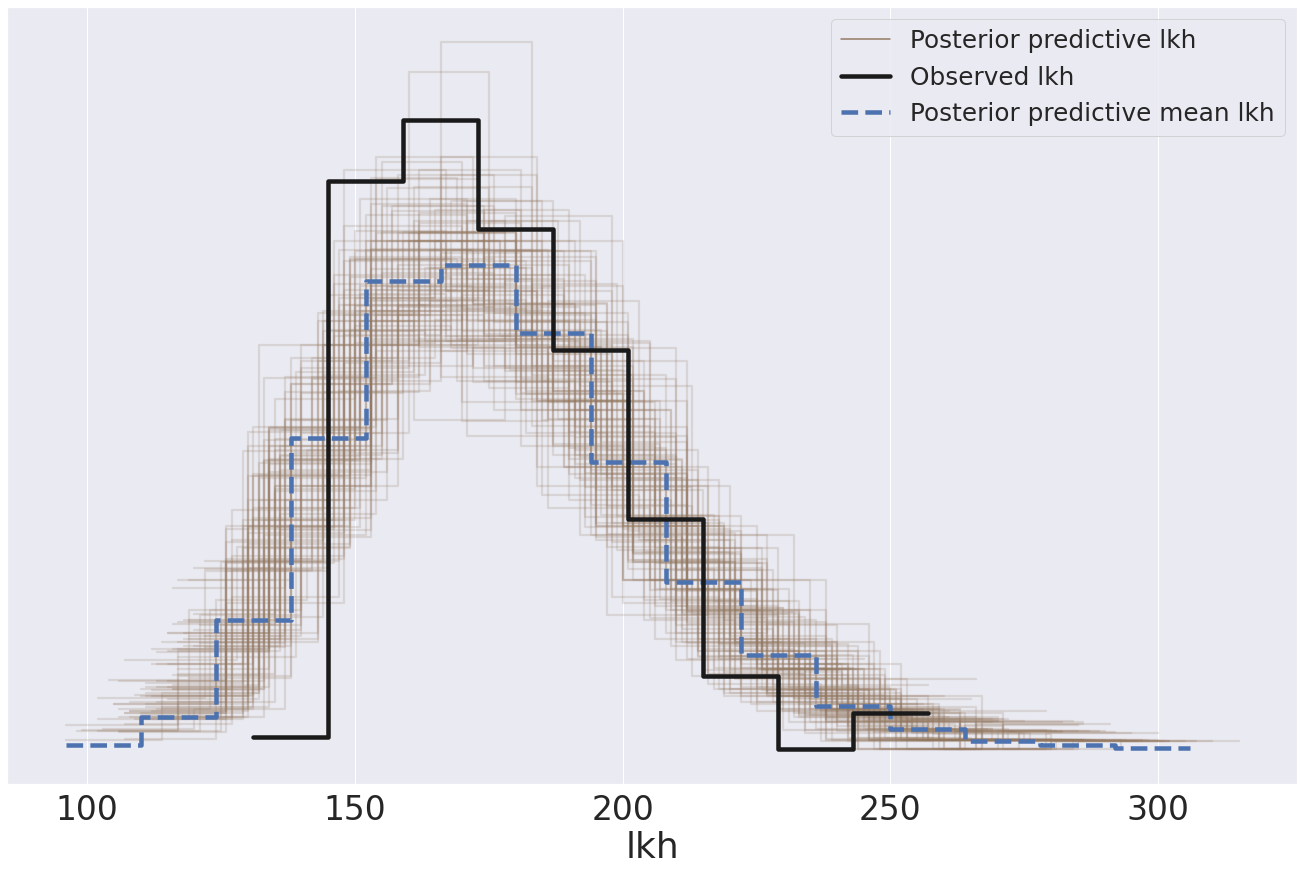

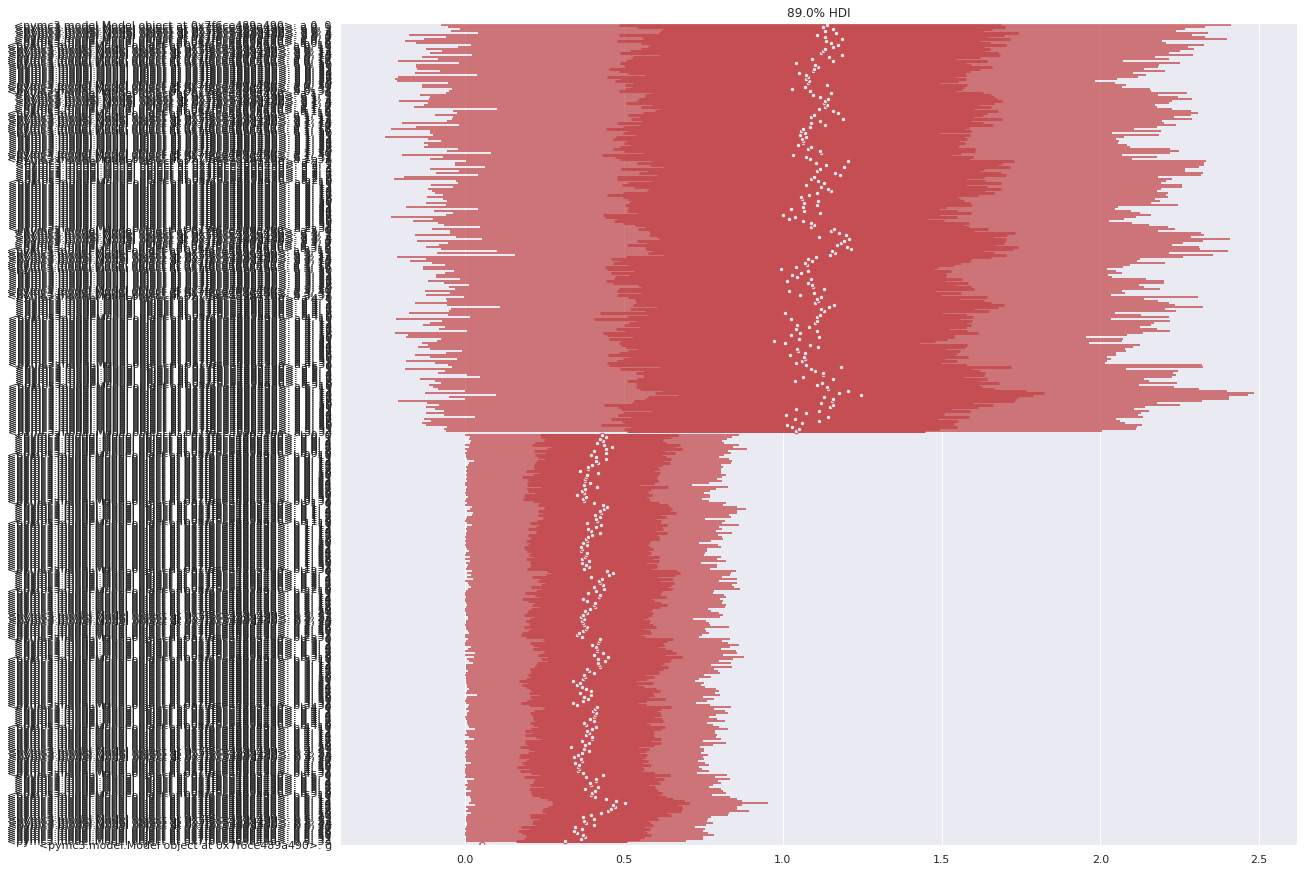

In [312]:
post_samples3 = pm.sample_posterior_predictive(trace3,100,model3)
data_ppc3 = az.from_pymc3(trace=trace3,model=model3,posterior_predictive=post_samples3)
az.plot_ppc(data_ppc3,figsize=(18,12))
az.plot_forest(trace3,model_names=[model3],figsize=(18,12),combined=True,colors='r',hdi_prob=0.89)


In [313]:
weekly_deaths_per_m

2015   2015-2018        2016        2017        2018  \
2020-01-07  200.806413  204.975661  191.529898  224.713967  202.852367   
2020-01-14  202.568782  203.346720  197.547630  216.205181  197.065288   
2020-01-21  200.806413  204.155452  204.291641  214.052356  197.471399   
2020-01-28  199.977063  199.469737  205.121673  197.034784  195.745428   
2020-02-04  203.812808  197.126579  200.348988  196.112144  188.232377   
2020-02-11  198.836707  196.639620  198.481416  187.910904  201.329452   
2020-02-18  212.520985  202.111880  184.993395  205.441054  205.492088   
2020-02-25  222.784193  211.090358  194.435010  212.309592  214.832637   
2020-03-03  180.694671  184.536639  187.379737  179.504634  190.567514   
2020-03-10  210.240272  206.141549  196.821352  192.011524  225.493047   
2020-03-17  195.519306  194.730456  181.673267  188.013420  213.715833   
2020-03-24  191.476224  191.050028  190.803620  176.326653  205.593616   
2020-03-31  205.160502  189.826744  180.428219  178.581994  195.136261   
2020-04-07  187.225804  190.619261  184.682133  188.833544  201.735563   
2020-04-14  190.024861  181.854426  177.419353  174.583890  185.389601   
2020-04-21  191.579892  180.065682  182.088283  176.941746  169.652806   
2020-04-28  177.480939  177.251113  178.768155  184.117831  168.637529   
2020-05-05  172.193832  172.211849  170.571588  176.429169  169.652806   
2020-05-12  170.846138  167.187737  163.101300  175.506529  159.296979   
2020-05-19  173.645195  164.823956  163.620070  166.997743  155.032815   
2020-05-26  170.846138  159.942850  156.046027  165.562526  147.316709   
2020-06-02  169.809450  160.959740  162.582530  164.434856  147.012126   
2020-06-09  165.559030  160.289480  155.008487  165.049949  155.540454   
2020-06-16  166.906725  157.327026  157.913599  158.693988  145.793794   
2020-06-23  164.729680  157.077964  157.913599  154.798399  150.870179   
2020-06-30  156.228841  160.442696  162.790038  157.566318  165.185586   
2020-07-07  176.962596  166.266708  160.092433  166.075104  161.936700   
2020-07-14  162.241630  161.717190  168.392754  155.516008  160.718367   
2020-07-21  157.058191  163.268699  163.412562  157.976380  174.627664   
2020-07-28  162.034292  163.308804  174.099224  150.697779  166.403919   
2020-08-04  161.101273  164.020155  163.308808  155.926070  175.744468   
2020-08-11  159.027898  156.660825  159.366155  159.206565  149.042680   
2020-08-18  156.125172  157.667166  167.251460  154.695884  152.596150   
2020-08-25  163.174649  159.621116  161.337481  163.102154  150.870179   

                  2019        2020     excess  cum_excess   abs_excess  \
2020-01-07  197.935096  186.639645 -18.336016  -18.336016  -189.366840   
2020-01-14  181.516053  185.546442 -17.800279  -36.136295  -373.200803   
2020-01-21  184.537963  177.993400 -26.162052  -62.298347  -643.391728   
2020-01-28  182.019704  178.291546 -21.178191  -83.476538  -862.111377   
2020-02-04  188.466445  178.291546 -18.835033 -102.311571 -1056.631859   
2020-02-11  186.048917  176.204521 -20.435098 -122.746670 -1267.677158   
2020-02-18  176.680997  181.173628 -20.938253 -143.684922 -1483.918825   
2020-02-25  186.351108  176.502668 -34.587691 -178.272613 -1841.126278   
2020-03-03  150.491111  174.018114 -10.518525 -188.791138 -1949.757279   
2020-03-10  170.234256  181.968685 -24.172864 -212.964002 -2199.404681   
2020-03-17  184.235772  177.297725 -17.432732 -230.396733 -2379.442769   
2020-03-24  164.391897  187.037174  -4.012854 -234.409588 -2420.885879   
2020-03-31  167.715998  209.298771  19.472027 -214.937560 -2219.786783   
2020-04-07  171.040098  243.386843  52.767582 -162.169978 -1674.824884   
2020-04-14  162.377290  254.617024  72.762598  -89.407380  -923.362679   
2020-04-21  174.867851  244.380664  64.314982  -25.092398  -259.143975   
2020-04-28  171.040098  224.504238  47.253124   22.160726   228.866872   
2020-05-05  162.478021  222.715359  50.503511   72.664237   750.446373   
2020-05-12  165.49993

In [314]:
excess_2019 = weekly_deaths_per_m['2019'] - weekly_deaths_per_m['2015-2018']
excess_2020 = weekly_deaths_per_m['2020'] - weekly_deaths_per_m['2015-2018']

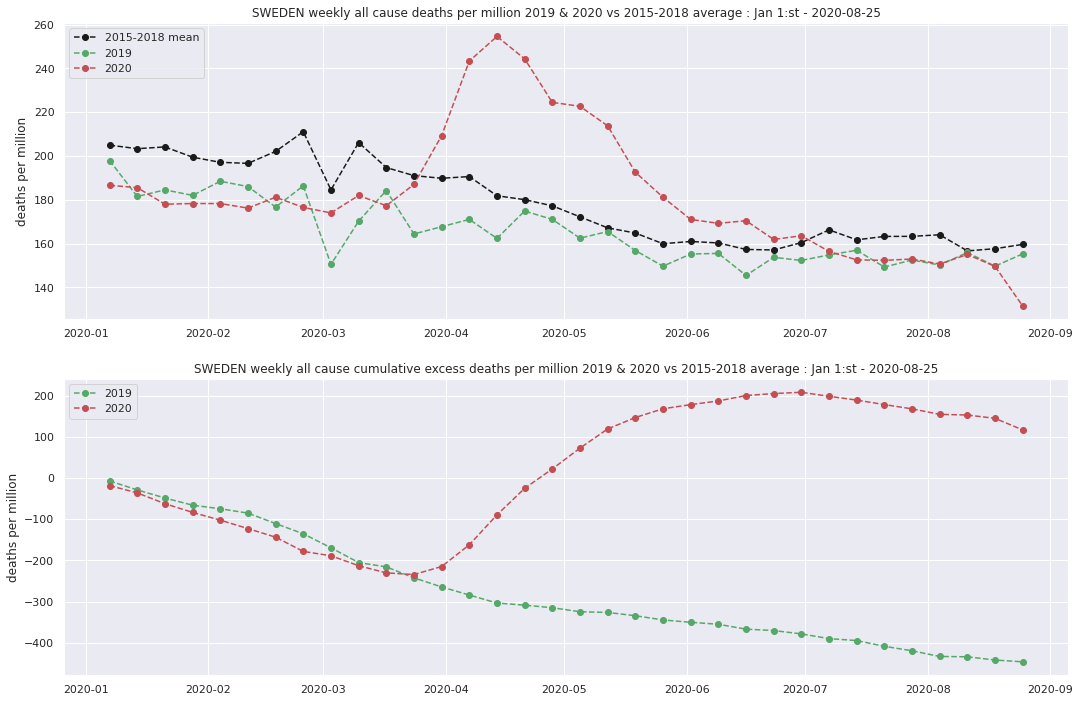

In [315]:
xticks = ['Jan','Feb','Mar','April','May','Jun','Jul','Aug']

plt.figure(figsize=(18,12))

plt.subplot(211)

plt.title('SWEDEN weekly all cause deaths per million 2019 & 2020 vs 2015-2018 average : Jan 1:st - {}'.format(last_week))
plt.plot(weekly_deaths_per_m['2015-2018'],'o--',color='k',label='2015-2018 mean')
plt.plot(weekly_deaths_per_m['2019'],'o--',color='g',label='2019')
plt.plot(weekly_deaths_per_m['2020'],'o--',color='r',label='2020')
plt.ylabel('deaths per million')
plt.legend(loc='upper left')

plt.subplot(212)

plt.title('SWEDEN weekly all cause cumulative excess deaths per million 2019 & 2020 vs 2015-2018 average : Jan 1:st - {}'.format(last_week))

plt.plot(excess_2019.cumsum(),'o--',color='g',label='2019')
plt.plot(excess_2020.cumsum(),'o--',color='r',label='2020')

plt.ylabel('deaths per million')
plt.legend(loc='upper left')
plt.savefig('excess_deaths_2019_2020_cmp_15-18.jpg',format='jpg')

In [316]:
data.head()

year       week  dead_per_m  week_idx  year_idx        pop
0  2015 2020-01-07  200.806413         0         0  9747355.0
1  2015 2020-01-14  202.568782         1         0  9747355.0
2  2015 2020-01-21  200.806413         2         0  9747355.0
3  2015 2020-01-28  199.977063         3         0  9747355.0
4  2015 2020-02-04  203.812808         4         0  9747355.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [g, b, a]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 129 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


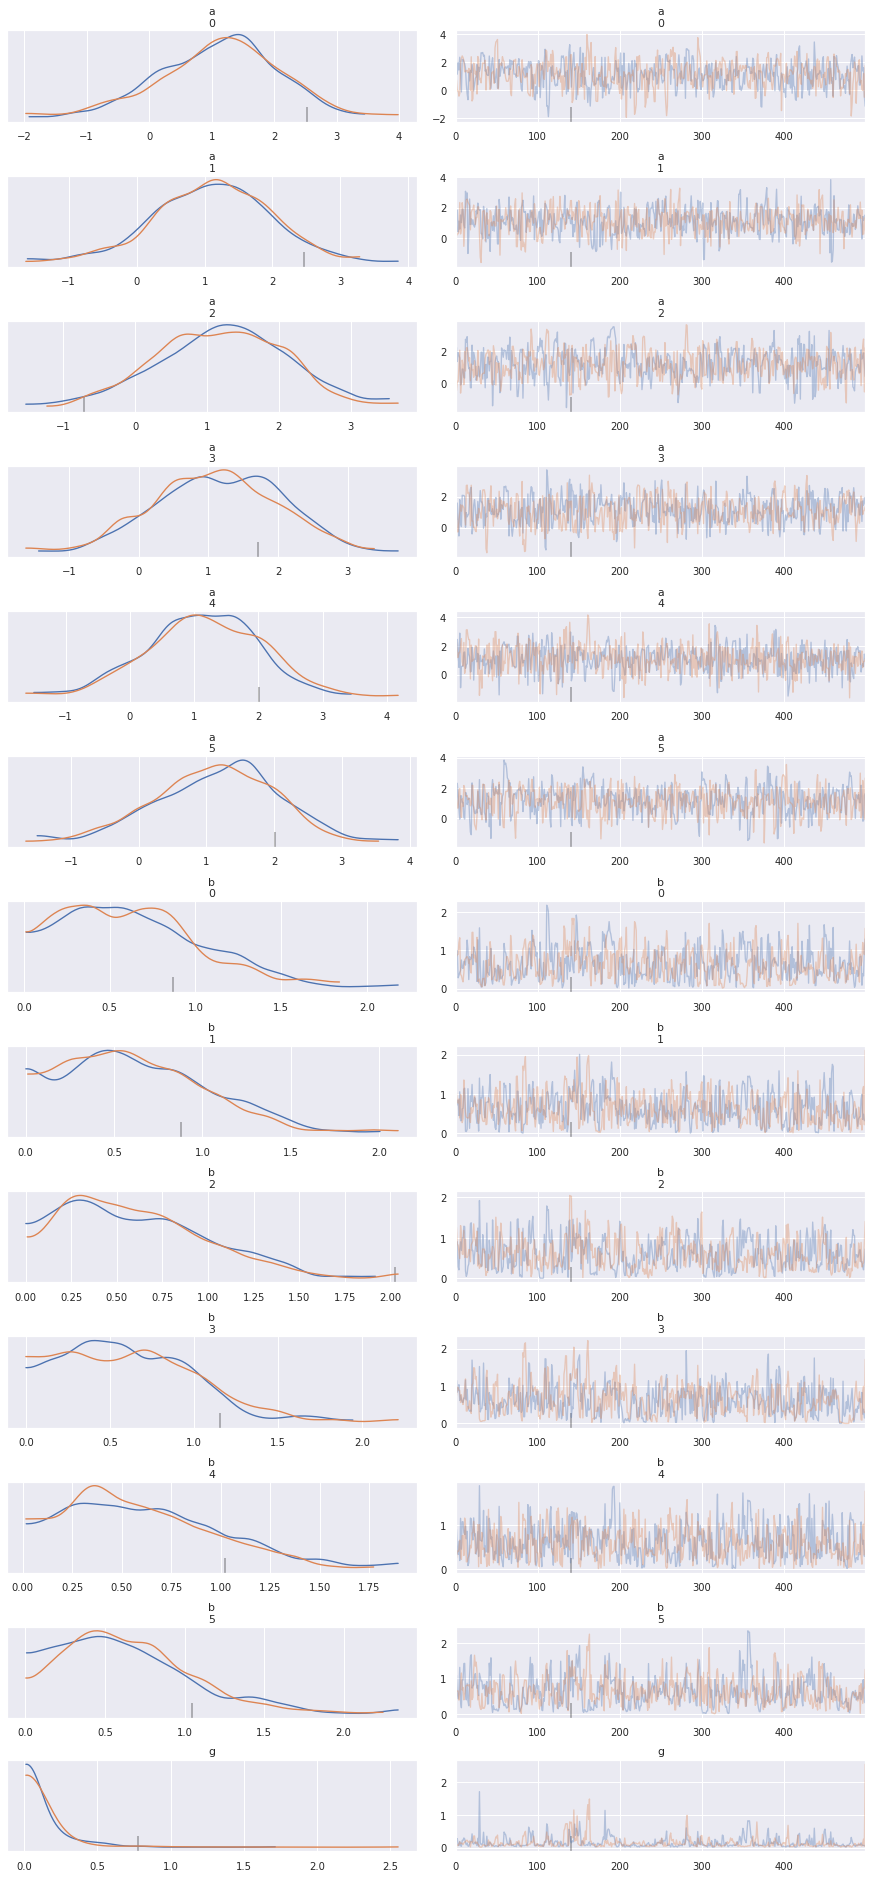

In [317]:
# ONLY condition on years

# Scientific, dynamic model, not a GLM

# Delta D = alpha * Pop^beta - gamma

# alpha = deaths per individual
# beta = Elasticity (diminishing returns)
# gamma = death loss (e.g. better health care)

# D ~ Poisson(lambda)
# lambda = exp(a[year_idx]) * P^b[week_idx] / g
# a = pm.Normal('a',1,1,shape=len(unique_weeks))
# b = pm.Exponential('b',1,shape=len(unique_weeks))
# g = pm.Exponential(1)


model4 = pm.Model()

year_idx = data['year_idx'].values

with model4:
    
    a = pm.Normal('a',mu=1,sigma=1,shape=len(year_idx_map))
    b = pm.Exponential('b',1,shape=len(year_idx_map))
    g = pm.Exponential('g',1)
    
    lambda_ = np.exp(a[year_idx]) * np.log(data['pop'].values) ** b[year_idx] / g
    
    lkh = pm.Poisson('lkh',lambda_,observed=data['dead_per_m'].values.astype(int))
    
    step1 = pm.Metropolis()
    trace4 = pm.sample(500,tune=500,target_accept=0.95)
    
    result4 = pm.trace_to_dataframe(trace4)
    summary4 = az.summary(trace4)
    
    _= az.plot_trace(trace4)

In [318]:
summary4


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  1.116  0.937  -0.678    2.772      0.040    0.031     543.0   470.0   
a[1]  1.104  0.837  -0.406    2.788      0.031    0.023     749.0   651.0   
a[2]  1.197  0.897  -0.437    2.920      0.043    0.035     433.0   322.0   
a[3]  1.123  0.879  -0.440    2.735      0.037    0.028     572.0   495.0   
a[4]  1.123  0.903  -0.553    2.786      0.034    0.032     692.0   405.0   
a[5]  1.132  0.894  -0.632    2.641      0.039    0.032     538.0   394.0   
b[0]  0.642  0.399   0.015    1.331      0.024    0.017     270.0   270.0   
b[1]  0.636  0.391   0.012    1.315      0.021    0.015     339.0   339.0   
b[2]  0.604  0.382   0.001    1.272      0.022    0.016     288.0   288.0   
b[3]  0.631  0.404   0.000    1.293      0.024    0.017     286.0   286.0   
b[4]  0.605  0.371   0.015    1.244      0.019    0.013     402.0   402.0   
b[5]  0.636  0.402   0.003    1.386      0.024    0.017     276.0   276.0   
g     0.152  0.187   0.012    0.438      0.012    0.008     255.0   255.0   

      ess_bulk  ess_tail  r_hat  
a[0]     535.0     445.0   1.00  
a[1]     745.0     454.0   1.00  
a[2]     426.0     297.0   1.00  
a[3]     573.0     661.0   1.01  
a[4]     677.0     582.0   1.00  
a[5]     519.0     415.0   1.00  
b[0]     277.0     454.0   1.01  
b[1]     343.0     436.0   1.01  
b[2]     284.0     359.0   1.00  
b[3]     241.0     239.0   1.01  
b[4]     410.0     596.0   1.00  
b[5]     267.0     311.0   1.01  
g        208.0     263.0   1.01

In [319]:

alphas = result4.iloc[:,0:6]
betas = result4.iloc[:,6:12]
gamma = result4['g']
betas

b__0      b__1      b__2      b__3      b__4      b__5
0    0.875614  0.249200  0.112500  0.354385  0.569882  0.633011
1    0.711343  0.863116  0.506167  1.150633  0.903743  1.085688
2    0.989263  0.722174  0.902384  0.835298  0.488197  0.584411
3    0.281265  0.840081  0.285419  0.897394  0.336213  0.422785
4    0.343634  0.450183  0.209148  1.034723  0.635267  0.632214
..        ...       ...       ...       ...       ...       ...
995  0.727726  0.081760  0.281118  0.088714  0.114610  0.674295
996  1.205573  1.096186  0.350425  0.878758  0.982480  0.291742
997  0.958340  1.188417  0.384598  0.991319  1.022604  0.721276
998  0.888463  0.215530  0.882778  0.286400  0.324852  0.724913
999  1.576818  2.106213  1.401987  1.710383  1.772085  1.253334

[1000 rows x 6 columns]

In [320]:
lambdas = pd.DataFrame(np.exp(alphas.values) * np.log(pop.T.values) ** betas.values) 
lambdas.columns=['2015','2016','2017','2018','2019','2020']
lambdas = lambdas.div(gamma,axis=0)
lambdas

2015        2016        2017        2018        2019        2020
0    182.485662  172.191809  177.384912  177.135491  162.925039  184.508063
1    182.426303  176.435809  171.885622  181.879746  161.108553  181.554367
2    176.966248  169.993692  174.973655  181.355734  166.661257  183.389812
3    183.987534  179.997275  177.841478  175.383021  166.924850  184.277862
4    184.573013  178.521874  177.065835  174.458911  165.256303  183.703076
..          ...         ...         ...         ...         ...         ...
995  178.953891  178.842837  172.210929  178.086133  164.265182  181.754078
996  183.203528  172.638049  179.539441  179.133305  168.994623  178.500393
997  180.081575  178.364285  179.919654  174.997262  163.453427  179.409308
998  181.436898  175.862372  176.023944  177.198824  165.165202  179.891357
999  179.573487  175.590589  177.951338  175.231186  165.634452  179.454584

[1000 rows x 6 columns]

In [321]:
lambdas.mean()

2015    181.345832
2016    176.142371
2017    177.049305
2018    177.344822
2019    164.815341
2020    181.432680
dtype: float64

Text(0, 0.5, 'average weekly deaths per million')

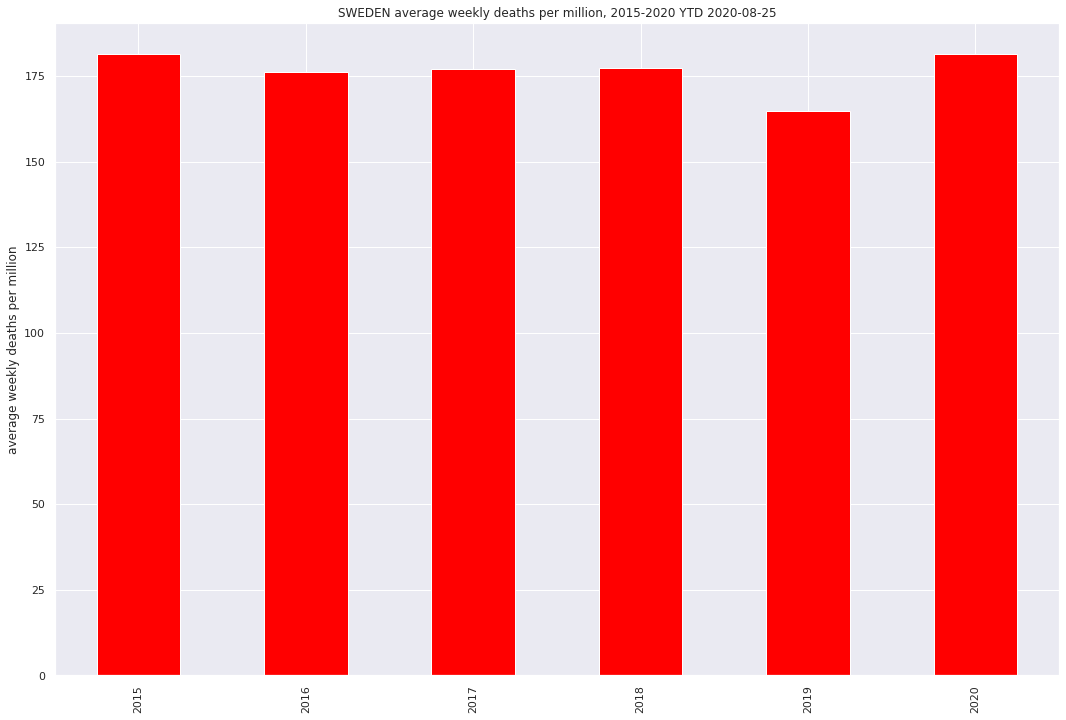

In [322]:
lambdas.mean().plot(kind='bar',
                    figsize=(18,12),color='red',
                    title='SWEDEN average weekly deaths per million, 2015-2020 YTD {}'.format(last_week))

plt.ylabel('average weekly deaths per million')

In [323]:
yearly_week_means = data.groupby('year').mean()
yearly_week_means

dead_per_m  week_idx  year_idx         pop
year                                            
2015  181.764899      16.5       0.0   9747355.0
2016  176.577114      16.5       1.0   9851017.0
2017  177.674431      16.5       2.0   9995153.0
2018  177.840717      16.5       3.0  10120242.0
2019  165.334022      16.5       4.0  10230185.0
2020  181.901456      16.5       5.0  10327589.0

In [324]:
CI = lambdas.quantile([0.055,0.945])
CI

2015        2016        2017        2018        2019        2020
0.055  177.670583  172.713105  173.329455  173.663853  161.420406  177.637439
0.945  185.002990  179.593980  180.993214  181.045925  168.421538  185.315762

In [325]:
samples = pm.Poisson.dist(lambdas.mean()).random(size=1000)
samples

array([[188, 181, 175, 178, 144, 157],
       [189, 145, 189, 169, 182, 178],
       [175, 179, 171, 186, 170, 174],
       ...,
       [182, 164, 214, 180, 188, 184],
       [163, 176, 171, 193, 172, 156],
       [150, 192, 175, 175, 153, 180]])

In [326]:
sample_CI = np.percentile(samples,[5.5,94.5],axis=0)
sample_CI

array([[162.   , 154.945, 157.   , 158.945, 146.   , 161.   ],
       [202.   , 199.   , 199.   , 199.   , 184.   , 203.   ]])

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

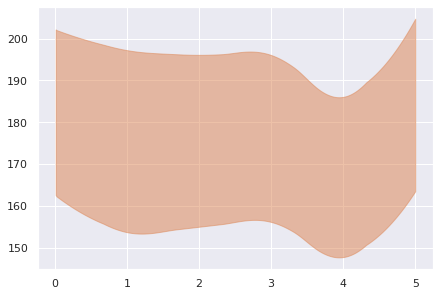

In [327]:
az.plot_hdi([0,1,2,3,4,5],samples,hdi_prob=0.89)

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


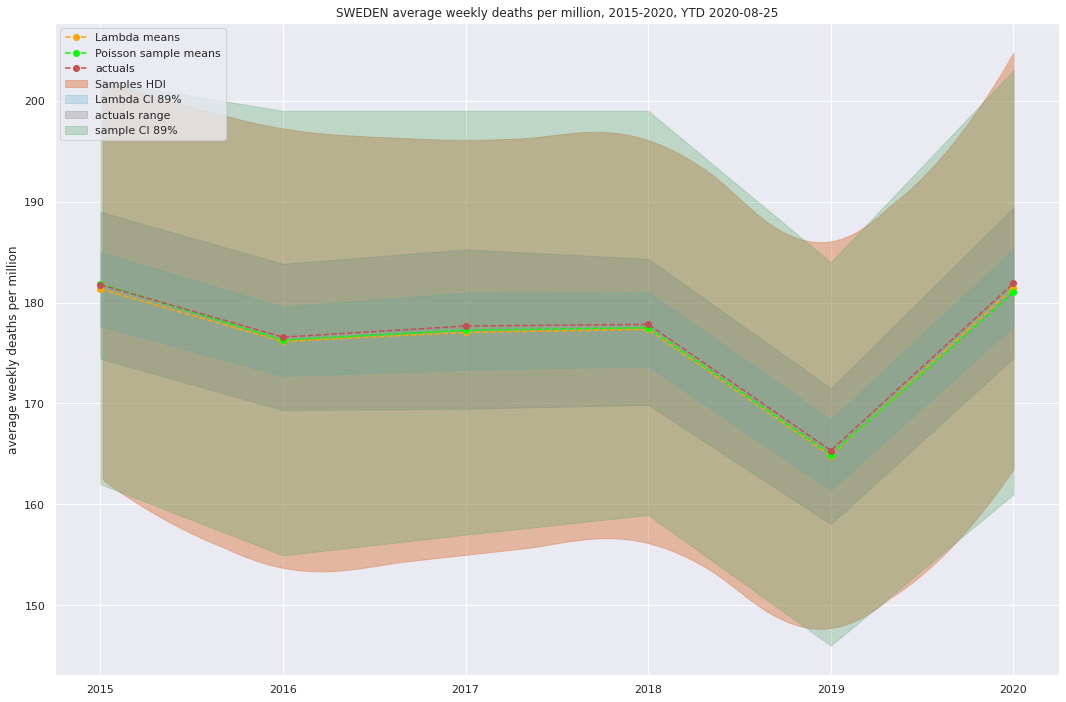

In [328]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN average weekly deaths per million, 2015-2020, YTD {}'.format(last_week))

ax = plt.gca()

az.plot_hdi([0,1,2,3,4,5],samples,hdi_prob=0.89,ax=ax,fill_kwargs={'alpha' : 0.5,'label' : 'Samples HDI'})

plt.plot(lambdas.mean(),'o--',color='orange',label='Lambda means')
plt.fill_between(lambdas.mean().index,CI.loc[0.055],CI.loc[0.945],color='c',alpha=0.3,label='Lambda CI 89%')
plt.fill_between(lambdas.mean().index,lambdas.min(),lambdas.max(),color='grey',alpha=0.3,label='actuals range')

plt.plot(lambdas.mean().index,samples.mean(axis=0),'o--',color='lime',label='Poisson sample means')
plt.fill_between(lambdas.mean().index,sample_CI[0],sample_CI[1],color='g',alpha=0.3,label='sample CI 89%')

plt.plot(yearly_week_means['dead_per_m'],'o--',color='r',label='actuals')
plt.ylabel('average weekly deaths per million')
plt.legend(loc='upper left')

In [329]:
post_samples4 = pm.sample_posterior_predictive(trace4,1000,model4)
post_samples4['lkh'].shape

(1000, 204)

In [330]:
np.percentile(post_samples4['lkh'],[5.5,94.5])

array([153., 200.])

In [331]:
data_ppc4 = az.from_pymc3(trace=trace4,model=model4,posterior_predictive=post_samples4)
data_ppc4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot:xlabel='lkh'>], dtype=object)

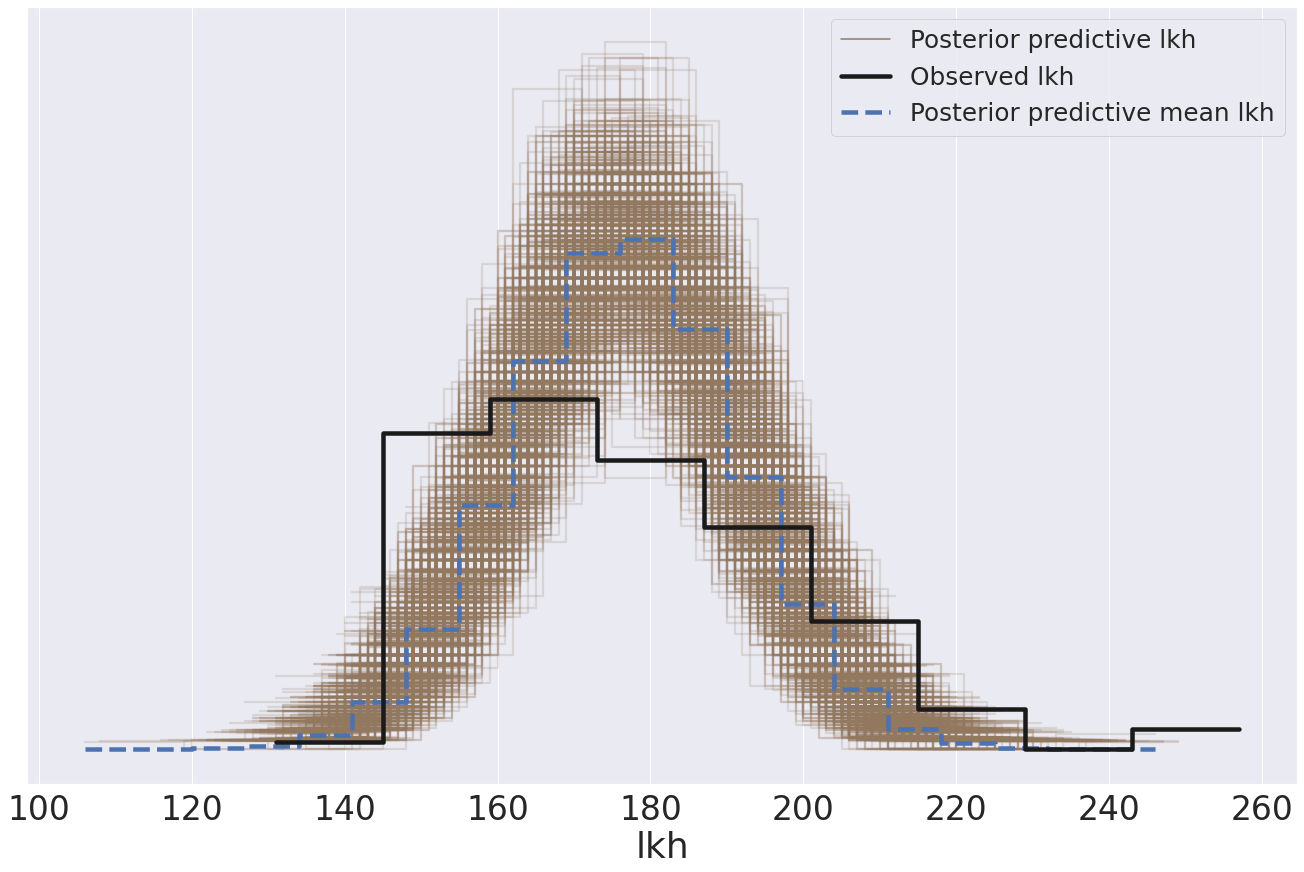

In [332]:
az.plot_ppc(data_ppc4,figsize=(18,12),)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

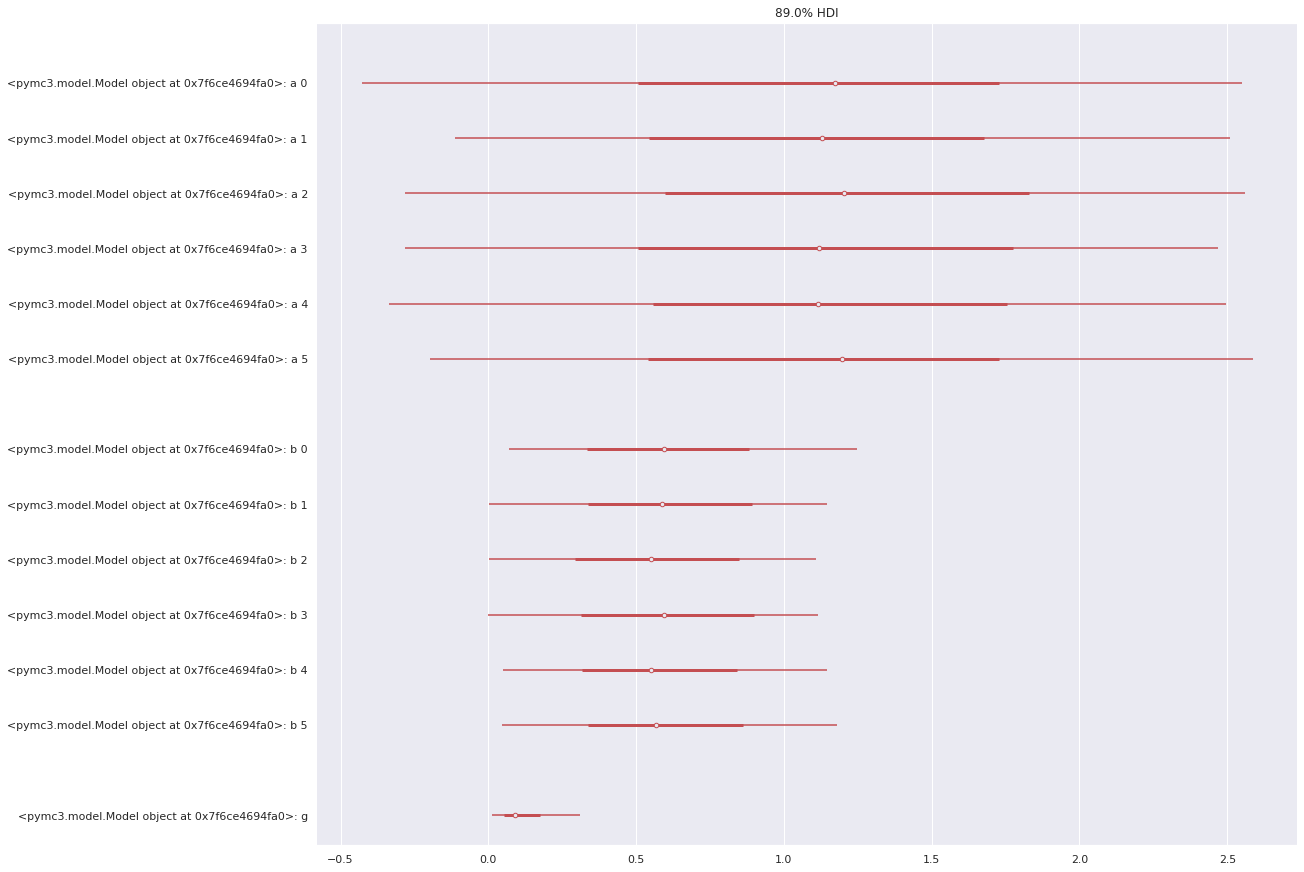

In [333]:
az.plot_forest(trace4,model_names=[model4],figsize=(18,12),combined=True,colors='r',hdi_prob=0.89)


In [334]:
scb_daily = parse_scb_prel(YTD=False)
scb_daily.drop('2015-2019',axis=1,inplace=True)
scb_daily = scb_daily.astype(float)
scb_daily.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Freq: D
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2015    366 non-null    float64
 1   2016    366 non-null    float64
 2   2017    366 non-null    float64
 3   2018    366 non-null    float64
 4   2019    366 non-null    float64
 5   2020    366 non-null    float64
dtypes: float64(6)
memory usage: 20.0 KB


In [335]:
print (scb_daily.loc['2020-02-29'])
print (scb_daily.loc['2020-02-28'])

scb_daily.loc['2020-02-28'] += 0.5 * scb_daily.loc['2020-02-29']
scb_daily.loc['2020-03-01'] += 0.5 * scb_daily.loc['2020-02-29']

scb_daily.loc['2020-02-27' : '2020-03-02']

2015      0.000000
2016    248.358508
2017      0.000000
2018      0.000000
2019      0.000000
2020    250.436188
Name: 2020-02-29 00:00:00, dtype: float64
2015    267.828332
2016    261.645177
2017    306.429854
2018    312.519404
2019    265.834335
2020    238.119654
Name: 2020-02-28 00:00:00, dtype: float64


2015        2016        2017        2018        2019  \
2020-02-27  299.159194  268.799537  260.311649  309.435331  248.318120   
2020-02-28  267.828332  385.824431  306.429854  312.519404  265.834335   
2020-02-29    0.000000  248.358508    0.000000    0.000000    0.000000   
2020-03-01  276.924389  360.273144  325.901986  339.248037  276.137992   
2020-03-02  298.148521  254.490817  280.808629  311.491380  269.955798   

                  2020  
2020-02-27  261.726344  
2020-02-28  363.337748  
2020-02-29  250.436188  
2020-03-01  395.155461  
2020-03-02  244.277921

In [336]:
scb_daily.drop(pd.to_datetime('2020-02-29'),inplace=True)
scb_daily['2015-2018'] = scb_daily.loc[:,'2015' : '2018'].mean(axis=1)
scb_daily

2015        2016        2017        2018        2019  \
2020-01-01  298.148521  250.402611  347.423815  282.706698  309.109692   
2020-01-02  274.903043  277.998000  324.877137  320.743599  284.380917   
2020-01-03  283.999099  299.461081  317.703194  303.267185  279.229089   
2020-01-04  258.732276  265.733383  312.578949  292.986941  290.563111   
2020-01-05  270.860351  265.733383  311.554100  299.155087  283.350551   
...                ...         ...         ...         ...         ...   
2020-12-27  229.422760  254.490817  277.734082  246.725845  245.227023   
2020-12-28  276.924389  267.777486  279.783780  268.314357  221.528613   
2020-12-29  295.116502  280.042103  282.858327  270.370405  251.409216   
2020-12-30  286.020445  313.769802  281.833478  238.501650  232.862635   
2020-12-31  257.721603  295.372875  309.504402  265.230284  253.469948   

                  2020   2015-2018  
2020-01-01  260.699966  294.670411  
2020-01-02  307.913346  299.630445  
2020-01-03  262.752722  301.107640  
2020-01-04  279.174767  282.507887  
2020-01-05  271.990122  286.825730  
...                ...         ...  
2020-12-27    0.000000  252.093376  
2020-12-28    0.000000  273.200003  
2020-12-29    0.000000  282.096834  
2020-12-30    0.000000  280.031344  
2020-12-31    0.000000  281.957291  

[365 rows x 7 columns]

In [337]:
scb_daily.loc['2020-02-27' : '2020-03-03']

2015        2016        2017        2018        2019  \
2020-02-27  299.159194  268.799537  260.311649  309.435331  248.318120   
2020-02-28  267.828332  385.824431  306.429854  312.519404  265.834335   
2020-03-01  276.924389  360.273144  325.901986  339.248037  276.137992   
2020-03-02  298.148521  254.490817  280.808629  311.491380  269.955798   
2020-03-03  313.308615  309.681596  322.827439  312.519404  230.801904   

                  2020   2015-2018  
2020-02-27  261.726344  284.426428  
2020-02-28  363.337748  318.150505  
2020-03-01  395.155461  325.586889  
2020-03-02  244.277921  286.234837  
2020-03-03  267.884611  314.584263

In [338]:
scb_daily.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-01-01 to 2020-12-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   2015       365 non-null    float64
 1   2016       365 non-null    float64
 2   2017       365 non-null    float64
 3   2018       365 non-null    float64
 4   2019       365 non-null    float64
 5   2020       365 non-null    float64
 6   2015-2018  365 non-null    float64
dtypes: float64(7)
memory usage: 32.8 KB


In [339]:
pop['2015-2018'] = pop['2015' : '2018'].mean()
pop

year
2015          9747355.00
2016          9851017.00
2017          9995153.00
2018         10120242.00
2019         10230185.00
2020         10327589.00
2015-2018     9928441.75
Name: population, dtype: float64

In [340]:
scb_daily_per_m = scb_daily / (pop / 1e6)
scb_daily_per_m

2015       2016       2017       2018       2019       2020  \
2020-01-01  30.587633  25.418960  34.759229  27.934776  30.215455  25.243062   
2020-01-02  28.202835  28.220234  32.503468  31.693274  27.798218  29.814640   
2020-01-03  29.136017  30.399002  31.785726  29.966397  27.294627  25.441826   
2020-01-04  26.543845  26.975223  31.273053  28.950586  28.402528  27.031940   
2020-01-05  27.788087  26.975223  31.170518  29.560073  27.697500  26.336265   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  23.536925  25.833964  27.786877  24.379441  23.970927   0.000000   
2020-12-28  28.410209  27.182725  27.991946  26.512642  21.654409   0.000000   
2020-12-29  30.276573  28.427735  28.299550  26.715804  24.575237   0.000000   
2020-12-30  29.343391  31.851514  28.197015  23.566793  22.762309   0.000000   
2020-12-31  26.440158  29.983998  30.965449  26.207899  24.776673   0.000000   

            2015-2018  
2020-01-01  29.679422  
2020-01-02  30.179000  
2020-01-03  30.327784  
2020-01-04  28.454403  
2020-01-05  28.889300  
...               ...  
2020-12-27  25.391031  
2020-12-28  27.516906  
2020-12-29  28.413002  
2020-12-30  28.204964  
2020-12-31  28.398947  

[365 rows x 7 columns]

<AxesSubplot:>

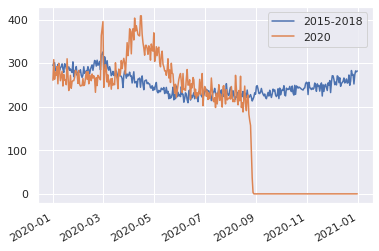

In [341]:
scb_daily.plot(y=['2015-2018','2020'])

<AxesSubplot:>

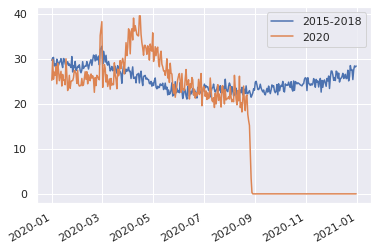

In [342]:
scb_daily_per_m.plot(y=['2015-2018','2020'])

In [343]:
scb_monthly_per_m = scb_daily_per_m.resample('M').sum()
scb_monthly_per_m

2015        2016        2017        2018        2019  \
2020-01-31  895.543692  886.862340  933.167392  871.361863  823.270425   
2020-02-29  836.442163  783.370858  807.459972  827.986774  734.638424   
2020-03-31  893.677328  843.546356  828.069427  935.561058  762.436643   
2020-04-30  797.766952  768.378859  775.776781  773.539355  723.760860   
2020-05-31  758.054872  725.322253  751.783685  688.516053  702.207169   
2020-06-30  701.649203  678.738117  682.367761  660.174953  649.833714   
2020-07-31  729.540977  734.971083  694.979517  737.376517  677.128342   
2020-08-31  695.946424  726.774765  699.696108  689.836606  687.804469   
2020-09-30  717.098550  698.035777  693.338963  691.055579  672.193151   
2020-10-31  741.050222  763.295067  760.294057  739.103394  739.070024   
2020-11-30  748.515678  767.860105  747.374697  701.010517  728.494615   
2020-12-31  811.038875  858.642106  827.351685  793.449232  776.033597   

                   2020   2015-2018  
2020-01-31   806.982917  896.697159  
2020-02-29   719.824787  813.828888  
2020-03-31   843.456160  875.403348  
2020-04-30  1030.592716  778.768833  
2020-05-31   864.624554  730.636654  
2020-06-30   718.135291  680.544484  
2020-07-31   678.183673  724.186223  
2020-08-31   535.967842  702.980165  
2020-09-30     0.000000  699.753694  
2020-10-31     0.000000  750.915241  
2020-11-30     0.000000  740.921190  
2020-12-31     0.000000  822.470120

<AxesSubplot:>

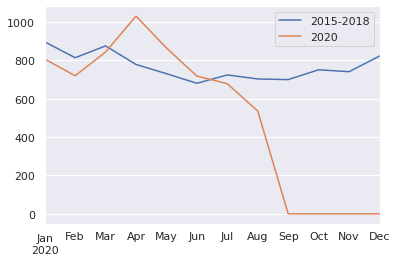

In [344]:
scb_monthly_per_m.plot(y=['2015-2018','2020'])

In [345]:
scb_transaction = scb_monthly_per_m.unstack().reset_index()
scb_transaction.columns=['year','month','dead_per_m']
scb_transaction = scb_transaction.loc[scb_transaction['year'] != '2015-2018']
scb_transaction

year      month  dead_per_m
0   2015 2020-01-31  895.543692
1   2015 2020-02-29  836.442163
2   2015 2020-03-31  893.677328
3   2015 2020-04-30  797.766952
4   2015 2020-05-31  758.054872
..   ...        ...         ...
67  2020 2020-08-31  535.967842
68  2020 2020-09-30    0.000000
69  2020 2020-10-31    0.000000
70  2020 2020-11-30    0.000000
71  2020 2020-12-31    0.000000

[72 rows x 3 columns]

In [346]:
scb_transaction['monthNr'] = scb_transaction['month'].dt.month
scb_transaction['year_month'] = scb_transaction['year'].astype(
    str).str.cat(scb_transaction['monthNr'].astype(str),'_')

In [347]:
scb_transaction

year      month  dead_per_m  monthNr year_month
0   2015 2020-01-31  895.543692        1     2015_1
1   2015 2020-02-29  836.442163        2     2015_2
2   2015 2020-03-31  893.677328        3     2015_3
3   2015 2020-04-30  797.766952        4     2015_4
4   2015 2020-05-31  758.054872        5     2015_5
..   ...        ...         ...      ...        ...
67  2020 2020-08-31  535.967842        8     2020_8
68  2020 2020-09-30    0.000000        9     2020_9
69  2020 2020-10-31    0.000000       10    2020_10
70  2020 2020-11-30    0.000000       11    2020_11
71  2020 2020-12-31    0.000000       12    2020_12

[72 rows x 5 columns]

In [348]:
scb_transaction.set_index('year_month',inplace=True)


In [349]:
scb_transaction = (scb_transaction.loc[scb_transaction['dead_per_m'] > 0 ]).copy()
scb_transaction

year      month   dead_per_m  monthNr
year_month                                       
2015_1      2015 2020-01-31   895.543692        1
2015_2      2015 2020-02-29   836.442163        2
2015_3      2015 2020-03-31   893.677328        3
2015_4      2015 2020-04-30   797.766952        4
2015_5      2015 2020-05-31   758.054872        5
...          ...        ...          ...      ...
2020_4      2020 2020-04-30  1030.592716        4
2020_5      2020 2020-05-31   864.624554        5
2020_6      2020 2020-06-30   718.135291        6
2020_7      2020 2020-07-31   678.183673        7
2020_8      2020 2020-08-31   535.967842        8

[68 rows x 4 columns]

In [350]:
monthly_means=scb_transaction.loc[scb_transaction.year.isin(
    ['2015','2016','2017','2018'])].groupby('monthNr')['dead_per_m'].mean()

monthly_mins=scb_transaction.loc[scb_transaction.year.isin(
    ['2015','2016','2017','2018'])].groupby('monthNr')['dead_per_m'].min()

monthly_maxs=scb_transaction.loc[scb_transaction.year.isin(
    ['2015','2016','2017','2018'])].groupby('monthNr')['dead_per_m'].max()

scb_transaction['monthly_mean'] = scb_transaction['monthNr'].apply(lambda x : monthly_means.loc[x])
scb_transaction['monthly_min'] = scb_transaction['monthNr'].apply(lambda x : monthly_mins.loc[x])
scb_transaction['monthly_max'] = scb_transaction['monthNr'].apply(lambda x : monthly_maxs.loc[x])

scb_transaction

year      month   dead_per_m  monthNr  monthly_mean  monthly_min  \
year_month                                                                     
2015_1      2015 2020-01-31   895.543692        1    896.733822   871.361863   
2015_2      2015 2020-02-29   836.442163        2    813.814942   783.370858   
2015_3      2015 2020-03-31   893.677328        3    875.213542   828.069427   
2015_4      2015 2020-04-30   797.766952        4    778.865487   768.378859   
2015_5      2015 2020-05-31   758.054872        5    730.919216   688.516053   
...          ...        ...          ...      ...           ...          ...   
2020_4      2020 2020-04-30  1030.592716        4    778.865487   768.378859   
2020_5      2020 2020-05-31   864.624554        5    730.919216   688.516053   
2020_6      2020 2020-06-30   718.135291        6    680.732508   660.174953   
2020_7      2020 2020-07-31   678.183673        7    724.217023   694.979517   
2020_8      2020 2020-08-31   535.967842        8    703.063476   689.836606   

            monthly_max  
year_month               
2015_1       933.167392  
2015_2       836.442163  
2015_3       935.561058  
2015_4       797.766952  
2015_5       758.054872  
...                 ...  
2020_4       797.766952  
2020_5       758.054872  
2020_6       701.649203  
2020_7       737.376517  
2020_8       726.774765  

[68 rows x 7 columns]

In [351]:
scb_transaction.groupby('year').sum()

dead_per_m  monthNr  monthly_mean  monthly_min  monthly_max
year                                                              
2015  9326.324936       78   9218.188641  8909.306858  9533.688750
2016  9235.797685       78   9218.188641  8909.306858  9533.688750
2017  9201.660045       78   9218.188641  8909.306858  9533.688750
2018  9108.971900       78   9218.188641  8909.306858  9533.688750
2019  8676.871435       78   9218.188641  8909.306858  9533.688750
2020  6197.767940       36   6203.560016  5984.688136  6426.792922

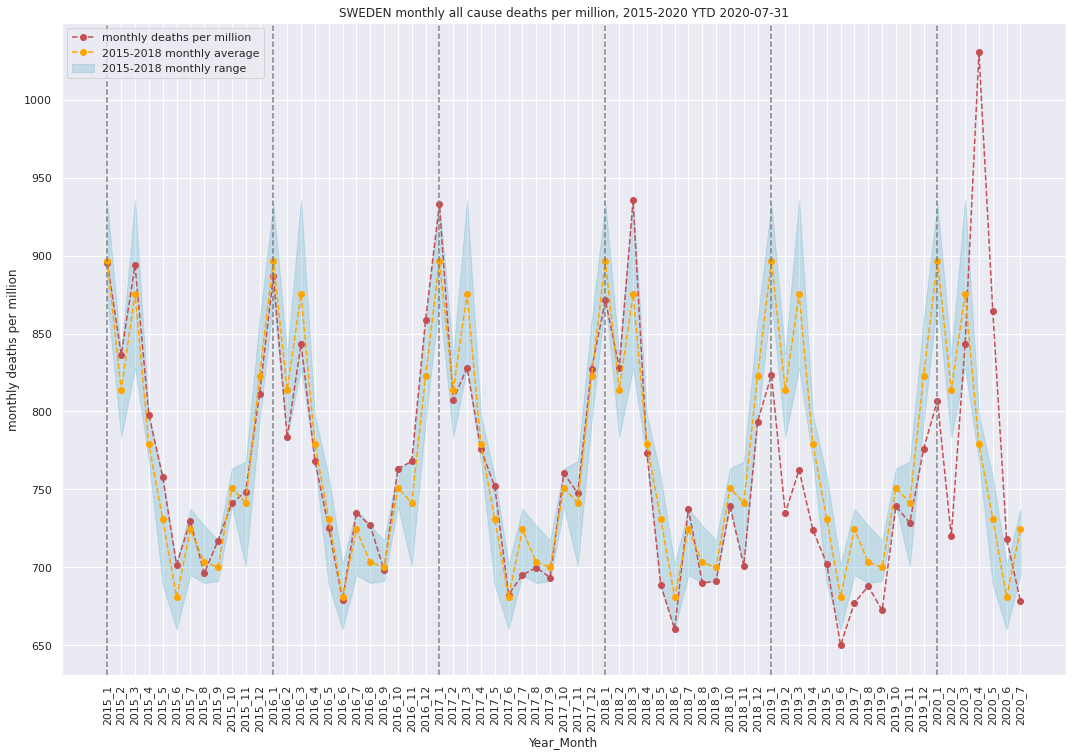

In [352]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN monthly all cause deaths per million, 2015-2020 YTD {}'.format(scb_transaction.iloc[-2,1].date()))

plt.plot(scb_transaction['dead_per_m'][:-1],'o--',color='r',label='monthly deaths per million')

plt.plot(scb_transaction['monthly_mean'][:-1],'o--',color='orange',label='2015-2018 monthly average')

plt.fill_between(scb_transaction.index[:-1],scb_transaction['monthly_min'][:-1],
                scb_transaction['monthly_max'][:-1],color='c',alpha=0.3,label='2015-2018 monthly range')


_= plt.xticks(rotation=90)

for month in range(len(scb_transaction)):
    if month % 12 == 0:
        plt.axvline(month,color='grey',ls='dashed')

plt.legend(loc='upper left')
plt.ylabel('monthly deaths per million')
plt.xlabel('Year_Month')

plt.savefig('scb_deaths_per_m_monthly_2015_2020.jpg',format='jpg',dpi=400)